In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

g_sequences = {}

g_sequences[0] = ['13524232514' ,'35421252143',  '51423252413', '14325242135'] #Group 1 sequences
g_sequences[1] = ['51423252413', '14325242135', '13524232514' ,'35421252143'] #Group 2 sequences

seq_length = len(g_sequences[0][0]) #Length of sequences

windowSizes = [2, 3, 4, 11]

digit_change = [4, 6, 8] #position of changed digit in changed sequence

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers


iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime = 0 # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1, 2, 3, 4,  5, 6, 7, 8, 9, 10, 11, 12]

num_pre_train_blocks = 1
num_train_blocks = 6
num_post_train_blocks = 1

num_pre_test_blocks = 1
num_test_blocks = 4 * 4
num_post_test_blocks = 1


test_session2_blocks_nums = list(range(9, 9 + 1 + 2 * 4 + 1))

test_session3_blocks_nums = list(range(19, 19 + 1 + 2 * 4 + 1))


In [2]:
# subjs_list = utils.read_dat_files_subjs_list(range(1,total_sub_num+1))

subjs_list = utils.read_dat_files_subjs_list(sub_nums)

# subjs_list = [utils.remove_error_trials(subj) for subj in subjs_list] ##Removing the error trials

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})


In [3]:
subjs_presses['is_trained_seq'] = subjs_presses.apply(utils.is_trained_seq, axis = 1)
subjs_presses['is_untrained_seq'] = subjs_presses.apply(utils.is_untrained_seq, axis = 1)
subjs_presses['is_rand_seq'] = subjs_presses.apply(utils.is_rand_seq, axis = 1)
subjs_presses['is_digit_changed'] = subjs_presses.apply(utils.is_digit_changed, axis = 1)


subjs['is_trained_seq'] = subjs.apply(utils.is_trained_seq, axis = 1)
subjs['is_untrained_seq'] = subjs.apply(utils.is_untrained_seq, axis = 1)
subjs['is_rand_seq'] = subjs.apply(utils.is_rand_seq, axis = 1)
subjs['is_digit_changed'] = subjs.apply(utils.is_digit_changed, axis = 1)


In [4]:
# rank_df = pd.DataFrame(index = subjs.index, dtype='int')
# for (subnum, seq, is_digit_changed), data in subjs.groupby(['SubNum', 'seq', 'is_digit_changed']):
#     data = data.sort_values(by = ['BN', 'TN'])
#     data['Rank'] = data.groupby(['BN', 'TN']).ngroup() + 1
#     rank_df.loc[data.index, 'Rank'] = data['Rank'].astype('int')
        

# subjs['Rank'] = rank_df['Rank'].astype('int')

In [5]:
# subjs.to_csv(utils.path_misc+'subjs.csv', index = False, sep = '\t')
# subjs_presses.to_csv(utils.path_misc+'subjs_presses.csv', index = False, sep = '\t')

In [6]:
# utils.remove_remaining_next_error_presses(subjs_presses)
# utils.remove_next_error_presses(subjs_presses)

## Sequence Specific Learning in Training:

TtestResult(statistic=1.421436661707203, pvalue=0.1829156494170563, df=11)
TtestResult(statistic=6.921815792684107, pvalue=2.514331140920297e-05, df=11)


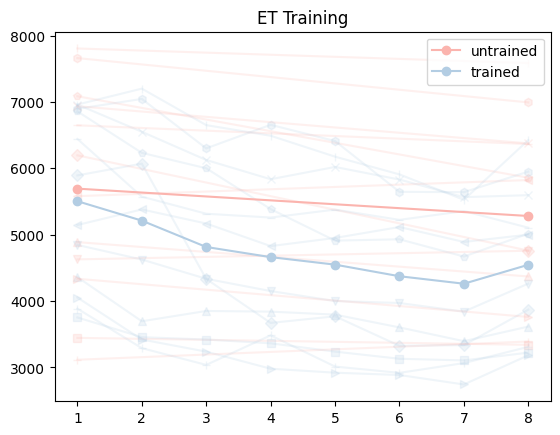

In [7]:
cmap = cm.Pastel1

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_', '|', '+']

induction_blocks = subjs[subjs['BN'] <= num_pre_train_blocks+num_train_blocks+num_post_test_blocks]

induction_blocks = utils.remove_error_trials(induction_blocks)

induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'norm_MT': 'median'
}).reset_index()


for subnum, subj_data in induction_grouped.groupby('SubNum'):
    for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
        plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))        

induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'norm_MT': ['mean', 'std']
}).reset_index()
for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
    plt.plot(data['BN'], data['norm_MT']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))


plt.title('ET Training')

plt.legend()

plt.show()

TtestResult(statistic=1.421436661707203, pvalue=0.1829156494170563, df=11)
TtestResult(statistic=6.921815792684107, pvalue=2.514331140920297e-05, df=11)


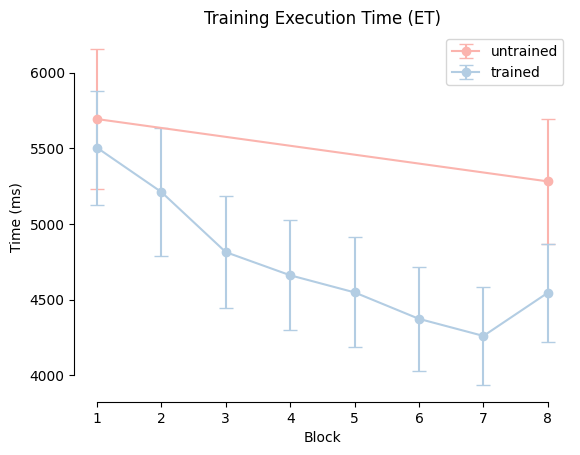

In [8]:
cmap = cm.Pastel1

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']

induction_blocks = subjs[subjs['BN'] <= num_pre_train_blocks+num_train_blocks+num_post_test_blocks]

induction_blocks = utils.remove_error_trials(induction_blocks)

induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'norm_MT': 'median'
}).reset_index()


# for subnum, subj_data in induction_grouped.groupby('SubNum'):
#     for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
#         plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))        

induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'norm_MT': ['mean', 'sem']
}).reset_index()
for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
    # plt.plot(data['BN'], data['norm_MT']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))
    plt.errorbar(data['BN'], data['norm_MT']['mean'], yerr=data['norm_MT']['sem'],  capsize= 5, marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))


plt.title('Training Execution Time (ET)')
plt.ylabel('Time (ms)')
plt.xlabel('Block')

plt.legend()

sns.despine(trim=True)
# plt.savefig(path_figs + "Training.pdf", format = 'pdf')
plt.show()

In [138]:
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [142]:
sns.light_palette('orange', n_colors=3)

[(0.952371654702472, 0.9416756878349389, 0.935002444561772),
 (0.976279216263584, 0.7937895755560861, 0.4656678841542943),
 (1.0, 0.6470588235294118, 0.0)]

TtestResult(statistic=0.39841931410976145, pvalue=0.6979455350217534, df=11)
TtestResult(statistic=6.189743955331121, pvalue=6.813820166439398e-05, df=11)


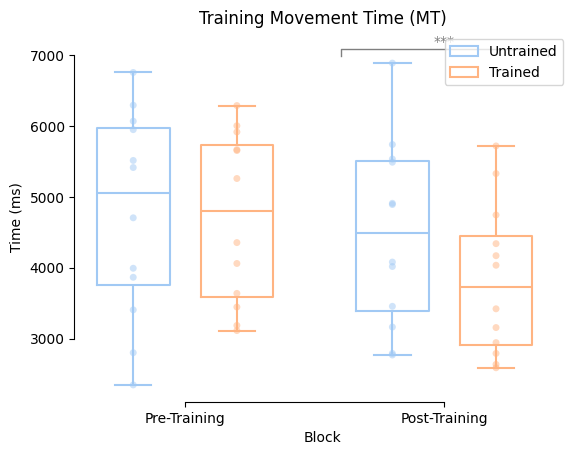

In [76]:
cmap = cm.Pastel1

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']

induction_blocks = subjs[subjs['BN'].isin([1, num_pre_train_blocks+num_train_blocks+num_post_test_blocks])]

induction_blocks = utils.remove_error_trials(induction_blocks)

induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'ET': 'median'
}).reset_index()


# for subnum, subj_data in induction_grouped.groupby('SubNum'):
#     for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
#         plt.plot(data['BN'], data['ET'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['ET'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['ET']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == False)]['ET'], 
                      induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == True)]['ET']))        

# induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
#     'ET': ['mean', 'sem']
# }).reset_index()
# for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
#     # plt.plot(data['BN'], data['ET']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))
#     plt.errorbar(data['BN'], data['ET']['mean'], yerr=data['ET']['sem'],  capsize= 5, marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))


sns.boxplot(x = 'BN', y = 'ET', hue = 'is_trained_seq', data = induction_grouped, palette = 'pastel', fill=False, gap = 0.3, width = 0.8)
sns.stripplot(x = 'BN', y = 'ET', hue = 'is_trained_seq', data = induction_grouped, palette = 'pastel', alpha = 0.5, jitter=0, dodge = True)


# significance bar on top of post training
x1, x2 = 0.6, 1.4
y, h, col = induction_grouped['ET'].max() + 100, 100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col, alpha = 0.5)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, alpha = 0.5)


plt.title('Training Movement Time (MT)')
plt.ylabel('Time (ms)')
plt.xlabel('Block')
plt.xticks(ticks = [0, 1], labels = ['Pre-Training', 'Post-Training'])


# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Untrained', 'Trained']
plt.legend(handles, labels, loc = 'upper right')

sns.despine(trim=True)
plt.savefig(path_figs + "Training.pdf", format = 'pdf')
plt.show()

## All Sessions Analysis:

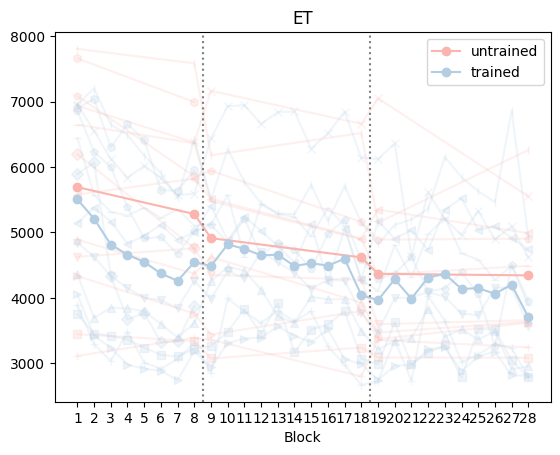

In [19]:
cmap = cm.Pastel1
test_blocks = subjs[subjs['BN'].isin(range(1,29))]

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_', '|', '+']


test_blocks = utils.remove_error_trials(test_blocks)

session_grouped = test_blocks.groupby(['BN', 'SubNum', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'median'
}).reset_index()

for subnum, subj_data in session_grouped.groupby('SubNum'):
    for idx, ((flag_trained, flag_untrained), data) in enumerate(subj_data.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(1), alpha = 0.2)
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(0), alpha = 0.2)
            
        

session_grouped = session_grouped.groupby(['BN', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'mean'
}).reset_index()
for idx, ((flag_trained, flag_untrained), data) in enumerate(session_grouped.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(1), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(0), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))

plt.axvline(x=8.5, color='gray', linestyle='dotted')

plt.axvline(x=18.5, color='gray', linestyle='dotted')

plt.xticks(range(1,29))


plt.title('ET')

plt.xlabel('Block')

plt.legend()

plt.show()

### Error Analysis:

In [20]:
print("whole experiment number of trials: ", len(subjs))

print("whole experiment error trials: ", len(subjs[subjs['isError'] == 1]))


test_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

print("\n \ntest blocks number of trials: ", len(test_blocks))
print("test blocks error trials: ", len(test_blocks[test_blocks['isError'] == 1]))

non_test_blocks = subjs[~subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]
print("non test blocks error trials: ", len(non_test_blocks[non_test_blocks['isError'] == 1]))




session1_blocks = subjs[subjs['BN'].isin(range(1,9))]
print("\n \nfirst sessions number of trials: ", len(session1_blocks))
print("first sessions error trials: ", len(session1_blocks[session1_blocks['isError'] == 1]))

session2_blocks = subjs[subjs['BN'].isin(range(9, 19))]
print("\n\nsecond session number of trials: ", len(session2_blocks))
print("second session error trials: ", len(session2_blocks[session2_blocks['isError'] == 1]))


session2_pre_post = subjs[subjs['BN'].isin([9,18])]
session3_pre_post = subjs[subjs['BN'].isin([19,28])]
print("\n \nsecond sessions error trials in pre and post: ", len(session2_pre_post[session2_pre_post['isError'] == 1]))
print("\n \nthird sessions error trials in pre and post: ", len(session3_pre_post[session3_pre_post['isError'] == 1]))


whole experiment number of trials:  9152
whole experiment error trials:  1602

 
test blocks number of trials:  4800
test blocks error trials:  799
non test blocks error trials:  803

 
first sessions number of trials:  3072
first sessions error trials:  618


second session number of trials:  3040
second session error trials:  495

 
second sessions error trials in pre and post:  97

 
third sessions error trials in pre and post:  88


In [281]:
test_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

print("test blocks number of trials: ", len(test_blocks))

subjs_test_error = test_blocks[test_blocks['isError'] == 1]

print("test blocks number of errors: ", len(subjs_test_error))


for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):
                for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                        print(f"digit {digit+1} : {len(digit_presses)}")


        if (flag_trained & ~flag_change):
                print(f"unchanged: {len(data)}")


        if (flag_rand):
                print(f"rand: {len(data)}")



test blocks number of trials:  4800
test blocks number of errors:  799
rand: 461
unchanged: 135
digit 5 : 85
digit 7 : 63
digit 9 : 55


seems like they are making more errors in changed compared to the previous experiment (changing only one digit)

median:  350.0


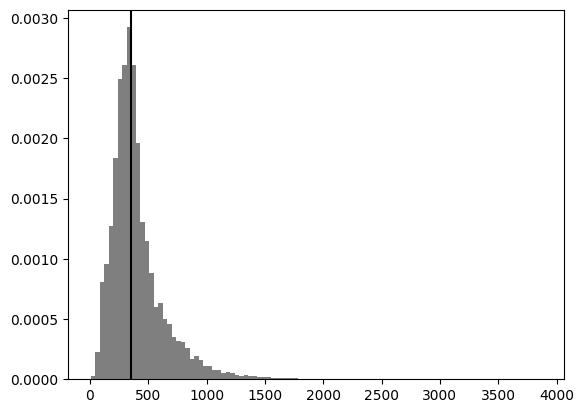

In [309]:
# All Presses Distribution
test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]
plt.hist(test_blocks['IPI_Value'], bins = 100, alpha = 0.5, density=True, color = 'black')
plt.axvline(test_blocks['IPI_Value'].median(), color = 'black')
print("median: ", test_blocks['IPI_Value'].median())
plt.show()

Random:
correct median:  400.0 N:  18594
error median:  350.0 N:  606
Trained Unchanged:
correct median:  305.0 N:  19030
error median:  382.5 N:  170
Trained Changed:
correct median:  355.0 N:  9332
error median:  325.0 N:  268


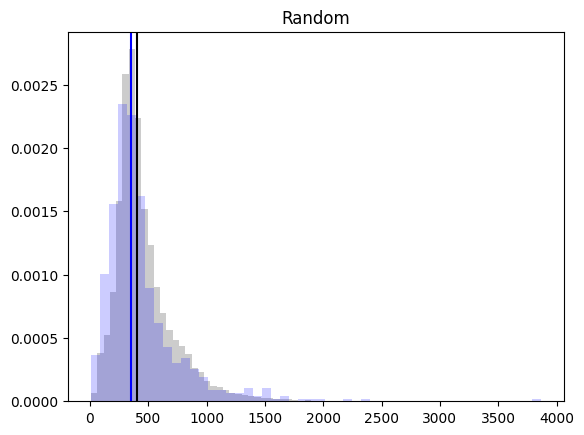

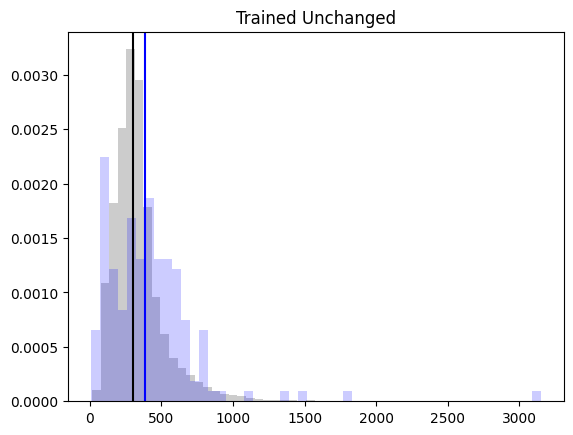

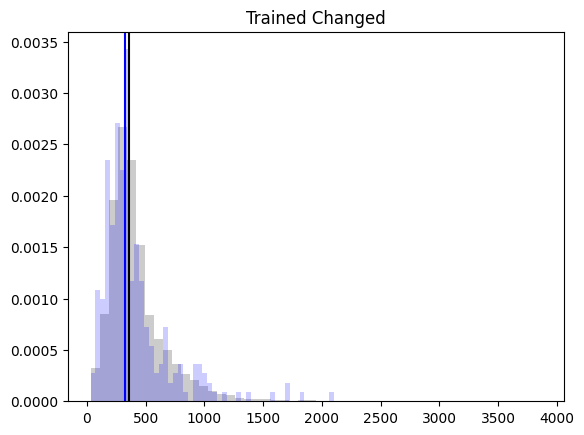

In [324]:
# plot Error vs non_error presses distribution within each condition:

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

for _ ,((flag_trained, flag_rand, flag_change), presses) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    if (flag_trained & flag_change):
        label = 'Trained Changed'
    if (flag_trained & ~flag_change):
        label = 'Trained Unchanged'
    if (flag_rand):
        label = 'Random'
        
    correct_presses = presses[presses['isPressError'] == 0]
    error_presses = presses[presses['isPressError'] == 1]
    plt.figure()
            
    print(label + ":")
    plt.hist(correct_presses['IPI_Value'], bins = 50, alpha = 0.2, density=True, color = 'black')
    plt.axvline(correct_presses['IPI_Value'].median(), color = 'black')
    print("correct median: ", correct_presses['IPI_Value'].median(), "N: ", len(correct_presses))
    plt.hist(error_presses['IPI_Value'], bins = 50, alpha = 0.2, density=True, color = 'blue')
    plt.axvline(error_presses['IPI_Value'].median(), color = 'blue')
    print("error median: ", error_presses['IPI_Value'].median(), "N: ", len(error_presses))
    plt.title(label)

error median:  345.0
non error median:  350.0


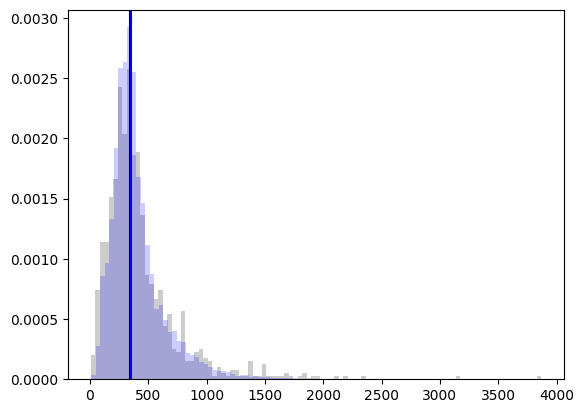

In [291]:
#plot Error vs non_error presses distribution:

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

test_blocks_error = test_blocks[test_blocks['isPressError'] == 1]

test_blocks_non_error = test_blocks[test_blocks['isPressError'] == 0]


plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
print("error median: ", test_blocks_error['IPI_Value'].median())

plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
print("non error median: ", test_blocks_non_error['IPI_Value'].median())


plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  345.0
non error median:  345.0


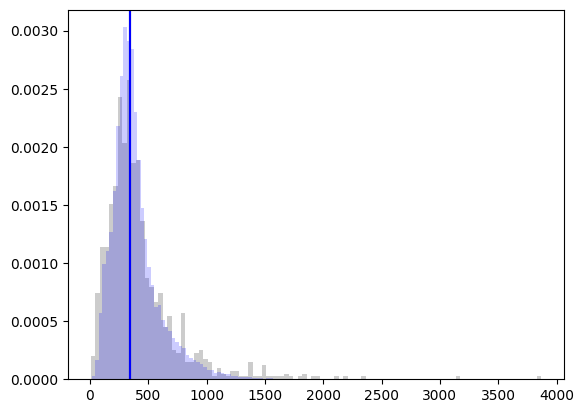

In [287]:
# presses within correct trials vs error presses

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

test_blocks_error = test_blocks[test_blocks['isPressError'] == 1]


test_blocks_non_error = utils.remove_error_trials_presses(test_blocks)


plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
print("error median: ", test_blocks_error['IPI_Value'].median())

plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
print("non error median: ", test_blocks_non_error['IPI_Value'].median())


plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


In [325]:
# test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

# test_blocks_error = test_blocks[test_blocks['isTrialError'] == 1]

# test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)

# test_blocks_non_error = utils.remove_error_trials_presses(test_blocks)


# plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
# plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
# print("error median: ", test_blocks_error['IPI_Value'].median())

# plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
# plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
# print("non error median: ", test_blocks_non_error['IPI_Value'].median())


# plt.show()

# # sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# # sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  325.0
non error median:  480.0
error median:  245.0
non error median:  320.0
error median:  300.0
non error median:  335.0
error median:  255.0
non error median:  305.0


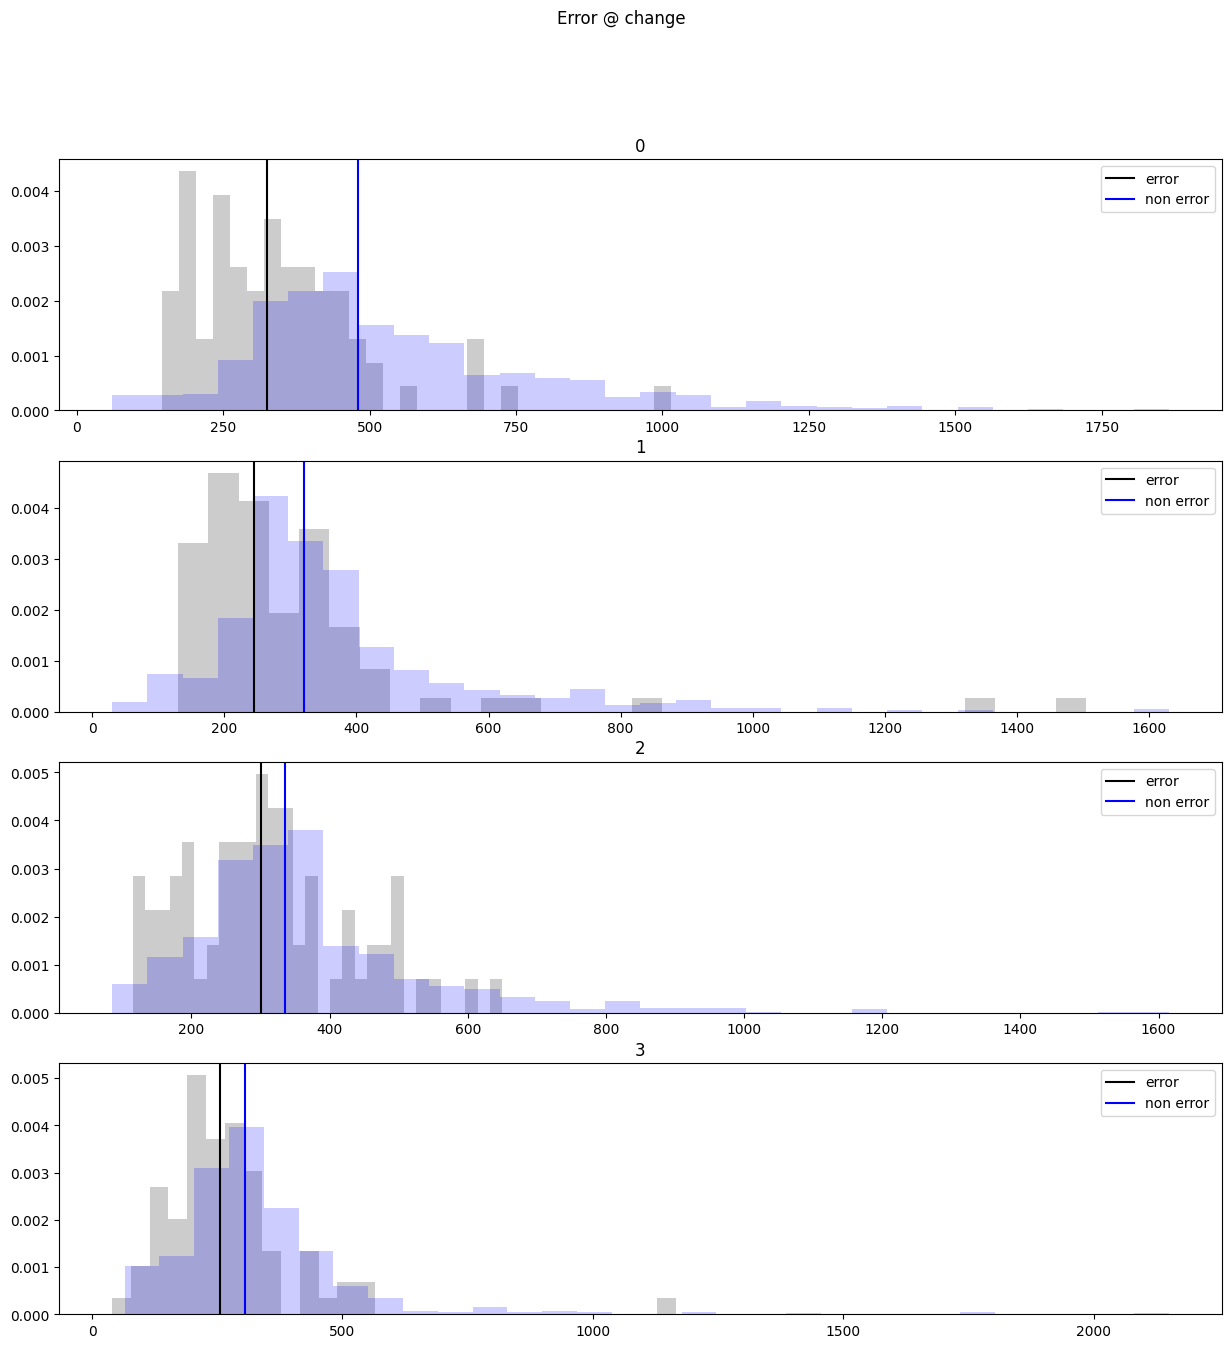

In [334]:
lookback_window = 4
fig, axs = plt.subplots(nrows=lookback_window , figsize= (15,15))

test_blocks_changed = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_trained_seq']) & (test_blocks_changed['is_digit_changed'])]

test_blocks_error = test_blocks_changed[test_blocks_changed['isTrialError'] == 1] 

test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)
# # test_blocks_error = test_blocks_error[test_blocks_error['isPressError'] == 1]

test_blocks_non_error = utils.remove_error_trials_presses(test_blocks_changed)

error_in_changed = test_blocks_error[test_blocks_error['N'] == (test_blocks_error['digitChangePos'] + 1)]
condition_rows = error_in_changed[error_in_changed['isPressError'] == 1][['SubNum','BN','TN']].drop_duplicates()
test_blocks_error = test_blocks_error.merge(condition_rows, on = ['SubNum', 'BN', 'TN'], how = 'inner')

for lookback in range(lookback_window):
    data_error = test_blocks_error[test_blocks_error['N'] == (test_blocks_error['digitChangePos'] + 1 - lookback)]
    data_non_error = test_blocks_non_error[test_blocks_non_error['N'] == (test_blocks_non_error['digitChangePos'] + 1 - lookback)]
    axs[lookback].hist(data_error['IPI_Value'],density=True, bins=30, alpha = 0.2, color = 'black' )
    axs[lookback].axvline(data_error['IPI_Value'].median(), color ='black', label = 'error')
    print("error median: ", data_error['IPI_Value'].median())

    axs[lookback].hist(data_non_error['IPI_Value'], density=True, bins = 30, alpha = 0.2, color = 'blue')
    axs[lookback].axvline(data_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
    print("non error median: ", data_non_error['IPI_Value'].median())
    axs[lookback].legend()
    axs[lookback].set_title(lookback)


fig.suptitle('Error @ change')
plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


rand: 450
unchanged: 124
digit 5 : 85
digit 7 : 62
digit 9 : 55


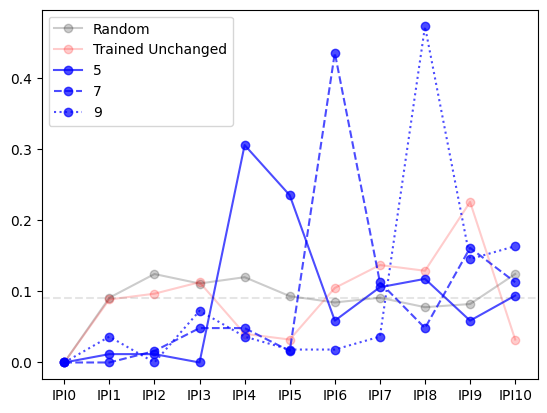

In [331]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

test_blocks = utils.remove_remaining_next_error_presses(test_blocks)

subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):
                for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                        print(f"digit {digit+1} : {len(digit_presses)}")
                        proportions = digit_presses['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        plt.plot(proportions.index.values, proportions, color = 'blue', label = digit+1, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

        if (flag_trained & ~flag_change):
                print(f"unchanged: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'red', label = 'Trained Unchanged', marker = 'o', alpha = 0.2)

        if (flag_rand):
                print(f"rand: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'black', label = 'Random', marker = 'o', alpha = 0.2)

plt.axhline(y = 1/11, color = 'black', linestyle = '--', alpha = 0.1)

plt.legend()
plt.show()

**************** 
 window 2 
 **************
rand: 102
unchanged: 19
digit 5 : 24
digit 7 : 14
digit 9 : 14
**************** 
 window 3 
 **************
rand: 115
unchanged: 34
digit 5 : 20
digit 7 : 12
digit 9 : 8
**************** 
 window 4 
 **************
rand: 113
unchanged: 33
digit 5 : 16
digit 7 : 19
digit 9 : 20
**************** 
 window 11 
 **************
rand: 120
unchanged: 38
digit 5 : 25
digit 7 : 17
digit 9 : 13


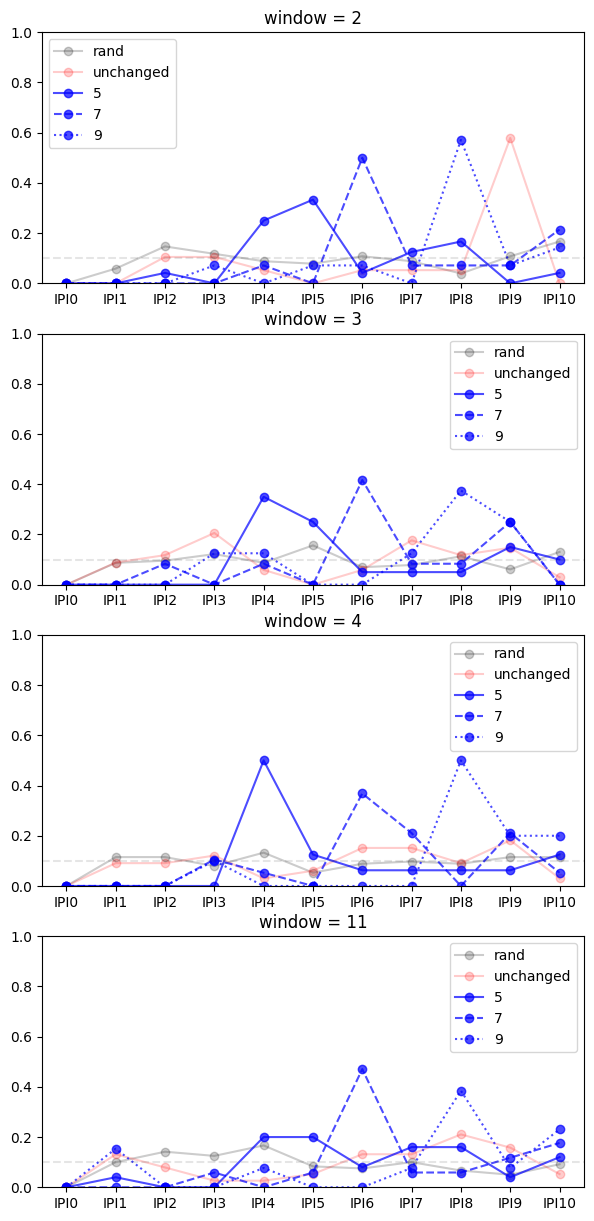

In [47]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']


fig, axs = plt.subplots(len(windowSizes), 1, figsize = (7,15))

for i, window in enumerate(windowSizes):
        print(f"**************** \n window {window} \n **************")

        test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

        test_blocks = test_blocks[test_blocks['windowSize'] == window]

        test_blocks = utils.remove_remaining_next_error_presses(test_blocks)


        subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

        for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
                if (flag_trained & flag_change):
                        for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                                print(f"digit {digit+1} : {len(digit_presses)}")
                                proportions = digit_presses['IPI_Number'].value_counts(sort=False)
                                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                                proportions /= sum(proportions)
                                axs[i].plot(proportions.index.values, proportions, color = 'blue', label = digit+1, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

                if (flag_trained & ~flag_change):
                        print(f"unchanged: {len(data)}")
                        proportions = data['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        axs[i].plot(proportions.index.values, proportions, color = 'red', label = 'unchanged', marker = 'o', alpha = 0.2)

                if (flag_rand):
                        print(f"rand: {len(data)}")
                        proportions = data['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        axs[i].plot(proportions.index.values, proportions, color = 'black', label = 'rand', marker = 'o', alpha = 0.2)

        axs[i].axhline(y = 0.1, color = 'black', linestyle = '--', alpha = 0.1)
        axs[i].legend()
        axs[i].set_ylim([0,1])
        axs[i].set_title(f'window = {window}')
plt.show()

In [333]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']
markers = ['.', '>', 'o', '^']

lookback_window = 4


# fig, axs = plt.subplots(len(windowSizes), 1, figsize = (7,15))

for i, window in enumerate(windowSizes):
        print(f"**************** \n window {window} \n **************")
        test_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]
        test_blocks = test_blocks[test_blocks['windowSize'] == window]
        print(len(test_blocks[test_blocks['isError'] == 1]))



**************** 
 window 2 
 **************
180
**************** 
 window 3 
 **************
194
**************** 
 window 4 
 **************
205
**************** 
 window 11 
 **************
220


**************** 
 window 2 
 **************
changed: 25
dist_to_change
-3     1
-2     3
-1     0
0     21
Name: count, dtype: int64
**************** 
 window 3 
 **************
changed: 17
dist_to_change
-3     0
-2     1
-1     1
0     15
Name: count, dtype: int64
**************** 
 window 4 
 **************
changed: 28
dist_to_change
-3     2
-2     1
-1     0
0     25
Name: count, dtype: int64
**************** 
 window 11 
 **************
changed: 22
dist_to_change
-3     2
-2     0
-1     2
0     18
Name: count, dtype: int64


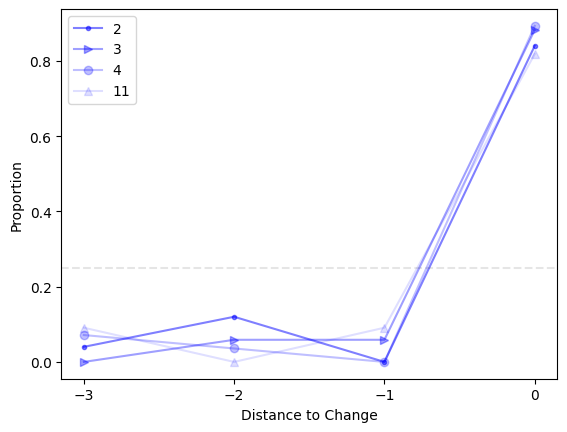

In [49]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']
markers = ['.', '>', 'o', '^']

lookback_window = 4


# fig, axs = plt.subplots(len(windowSizes), 1, figsize = (7,15))

for i, window in enumerate(windowSizes):
        print(f"**************** \n window {window} \n **************")

        test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

        test_blocks = test_blocks[test_blocks['windowSize'] == window]

        test_blocks = utils.remove_remaining_next_error_presses(test_blocks)

        subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

        for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
                if (flag_trained & flag_change):
                        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos'])
                        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, 1))]
                        print(f"changed: {len(data)}")
                        proportions = data['dist_to_change'].value_counts(sort = False)
                        proportions = proportions.reindex(range(-1 * lookback_window + 1, 1), fill_value = 0)
                        print(proportions)
                        proportions /= sum(proportions)
                        plt.plot(proportions.index.values, proportions, color = 'blue', label = f'{window}', marker = markers[i], alpha = (len(windowSizes) - i) / (2 * len(windowSizes)))
                        epsilon = 0.15
                        # plt.plot(proportions.index.values - epsilon * i + 0.3, proportions, color = 'blue', label = f'{window}', marker = markers[i], alpha = 0.1, linestyle='')


plt.axhline(y = 0.25, color = 'black', linestyle = '--', alpha = 0.1)
plt.xticks(proportions.index.values)
plt.xlabel('Distance to Change')
plt.ylabel('Proportion')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
# plt.legend()
plt.show()

IPI Analysis:

False True False
True False False
True False True
IPI:  -2 TtestResult(statistic=-4.466449844954608, pvalue=0.0015626457272327888, df=9)
IPI:  -1 TtestResult(statistic=-3.7907353070686893, pvalue=0.004277818884476701, df=9)
IPI:  0 TtestResult(statistic=1.6552705162834882, pvalue=0.13225391013786283, df=9)
IPI:  1 TtestResult(statistic=0.5610078229969647, pvalue=0.5884852101611623, df=9)
IPI:  2 TtestResult(statistic=-0.18441906643360348, pvalue=0.8577732500242538, df=9)


Text(0.5, 1.0, 'changed vs unchanged')

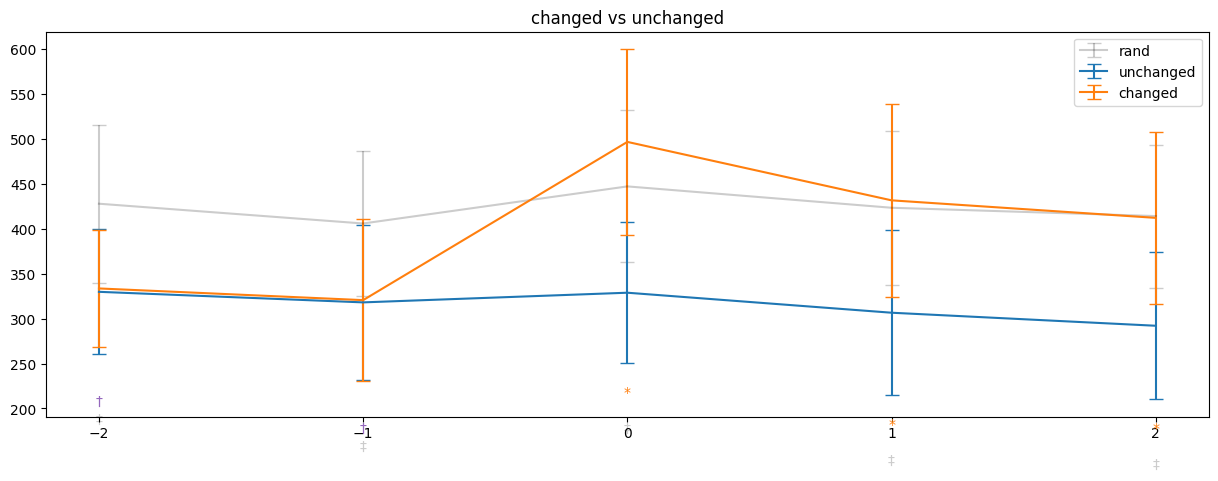

In [92]:
plt.figure(figsize=(15, 5))
cmap = cm.Pastel1
capsize = 5

lookback_window = 3

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    if (flag_trained & flag_change):
        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos']) 
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
        label = 'changed'

    if (flag_trained & ~flag_change):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'unchanged'

    if (flag_rand):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'rand'


    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    finger_agg = data.groupby(['dist_to_change']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()

    finger_agg = finger_agg.iloc[index_natsorted(finger_agg['dist_to_change'])].reset_index(drop=True)
    plt.errorbar(finger_agg['dist_to_change'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])
    plt.xticks(finger_agg['dist_to_change'])



#Statistical Signficance Tests
merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'dist_to_change'], suffixes=('_changed', '_unchanged'))
merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'dist_to_change'])
merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

for IPI in merged_df['dist_to_change'].unique():
    IPI_data = merged_df[merged_df['dist_to_change'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
    ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
    ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])

    
    # Add significance symbols just above the error bars
    changed_mean = IPI_data['IPI_Value_changed'].mean()
    changed_std = IPI_data['IPI_Value_changed'].std()
    unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
    unchanged_std = IPI_data['IPI_Value_unchanged'].std()
    rand_mean = IPI_data['IPI_Value_rand'].mean()
    rand_std = IPI_data['IPI_Value_rand'].std()

    y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
    y_pos_unchanged = unchanged_mean - unchanged_std 
    y_pos_rand = rand_mean - rand_std

    y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

    if ttest_changed_vs_unchanged.pvalue < 0.05:
        plt.text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

    if ttest_changed_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

    if ttest_unchanged_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)

    print('IPI: ', IPI, ttest_changed_vs_rand)





plt.legend(loc = 'upper right')

plt.title(f'changed vs unchanged')

IPI:  -2 TtestResult(statistic=-4.651674849151631, pvalue=0.0011992686343058345, df=9)
IPI:  -1 TtestResult(statistic=-4.0752900582393385, pvalue=0.002777538855506928, df=9)
IPI:  0 TtestResult(statistic=1.6373248164896255, pvalue=0.135988502619675, df=9)
IPI:  1 TtestResult(statistic=2.4241958746434067, pvalue=0.03834585160436596, df=9)
IPI:  2 TtestResult(statistic=0.22268088570756162, pvalue=0.8287554138218167, df=9)


Text(0.5, 1.0, 'changed vs unchanged')

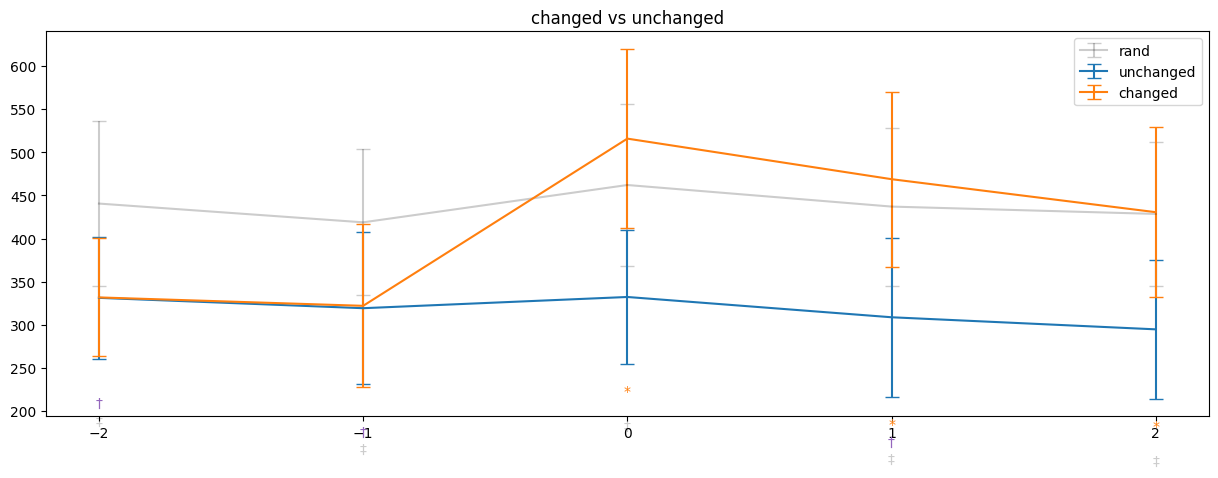

In [235]:
plt.figure(figsize=(15, 5))
cmap = cm.Pastel1
capsize = 5

lookback_window = 3

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_presses, axis = 1)

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    
    if (flag_trained & flag_change):
        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos']) 
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
        label = 'changed'

    if (flag_trained & ~flag_change):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'unchanged'

    if (flag_rand):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'rand'

    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    finger_agg = data.groupby(['dist_to_change']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()

    finger_agg = finger_agg.iloc[index_natsorted(finger_agg['dist_to_change'])].reset_index(drop=True)
    plt.errorbar(finger_agg['dist_to_change'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])
    plt.xticks(finger_agg['dist_to_change'])



#Statistical Signficance Tests
merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'dist_to_change'], suffixes=('_changed', '_unchanged'))
merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'dist_to_change'])
merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

for IPI in merged_df['dist_to_change'].unique():
    IPI_data = merged_df[merged_df['dist_to_change'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
    ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
    ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])

    
    # Add significance symbols just above the error bars
    changed_mean = IPI_data['IPI_Value_changed'].mean()
    changed_std = IPI_data['IPI_Value_changed'].std()
    unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
    unchanged_std = IPI_data['IPI_Value_unchanged'].std()
    rand_mean = IPI_data['IPI_Value_rand'].mean()
    rand_std = IPI_data['IPI_Value_rand'].std()

    y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
    y_pos_unchanged = unchanged_mean - unchanged_std 
    y_pos_rand = rand_mean - rand_std

    y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

    if ttest_changed_vs_unchanged.pvalue < 0.05:
        plt.text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

    if ttest_changed_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

    if ttest_unchanged_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)

    print('IPI: ', IPI, ttest_changed_vs_rand)





plt.legend(loc = 'upper right')

plt.title(f'changed vs unchanged')

333.5
427.75
IPI:  -2 TtestResult(statistic=-4.466449844954608, pvalue=0.0015626457272327888, df=9)
320.5
405.75
IPI:  -1 TtestResult(statistic=-3.7907353070686893, pvalue=0.004277818884476701, df=9)
IPI:  0 TtestResult(statistic=1.6552705162834882, pvalue=0.13225391013786283, df=9)
IPI:  1 TtestResult(statistic=0.5610078229969647, pvalue=0.5884852101611623, df=9)
IPI:  2 TtestResult(statistic=-0.18441906643360348, pvalue=0.8577732500242538, df=9)


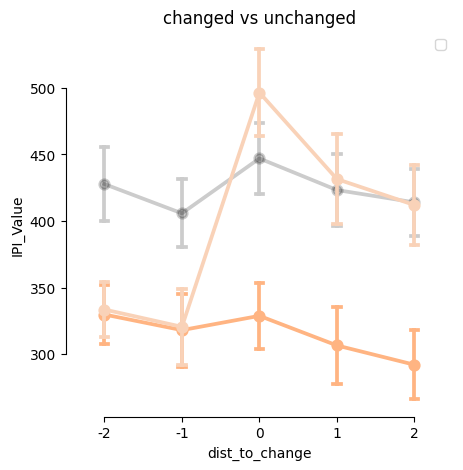

In [15]:
plt.figure(figsize=(5, 5))
cmap = cm.Pastel1
capsize = 5

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

lookback_window = 3

kwargs = {'changed': {'color': trained_pallet[1], 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

# session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_presses, axis = 1)
session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    
    if (flag_trained & flag_change):
        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos']) 
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
        label = 'changed'

    if (flag_trained & ~flag_change):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'unchanged'

    if (flag_rand):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'rand'

    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data


    sns.pointplot(data = data, x = 'dist_to_change', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1, **kwargs[label])



#Statistical Signficance Tests
merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'dist_to_change'], suffixes=('_changed', '_unchanged'))
merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'dist_to_change'])
merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

for IPI in merged_df['dist_to_change'].unique():
    IPI_data = merged_df[merged_df['dist_to_change'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
    ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
    ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])

    
    # Add significance symbols just above the error bars
    changed_mean = IPI_data['IPI_Value_changed'].mean()
    changed_std = IPI_data['IPI_Value_changed'].std()
    unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
    unchanged_std = IPI_data['IPI_Value_unchanged'].std()
    rand_mean = IPI_data['IPI_Value_rand'].mean()
    rand_std = IPI_data['IPI_Value_rand'].std()

    y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
    y_pos_unchanged = unchanged_mean - unchanged_std 
    y_pos_rand = rand_mean - rand_std

    y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

    # if ttest_changed_vs_unchanged.pvalue < 0.05:
        # plt.text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')
        # plt.text(IPI, (changed_mean + unchanged_mean)/2, '*', ha='center', va='bottom', color='C1')

    if ttest_changed_vs_rand.pvalue < 0.05:
    #     plt.text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')
        print(changed_mean)
        print(rand_mean)
        # plt.text(IPI + 2, (changed_mean + rand_mean)/2, '*', ha='center', va='bottom', color='C1')


    # if ttest_unchanged_vs_rand.pvalue < 0.05:
    #     plt.text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)

    print('IPI: ', IPI, ttest_changed_vs_rand)

# x = 3
# delta_x = 0.1
# y = 470
# delta_y = 100
# plt.plot([x + delta_x, x + 2 * delta_x, x + 2 * delta_x, x + delta_x], 
#          [y, y, y - delta_y, y - delta_y], color = 'black', alpha = 0.5, lw = 1)


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')


plt.title(f'changed vs unchanged')
plt.show()

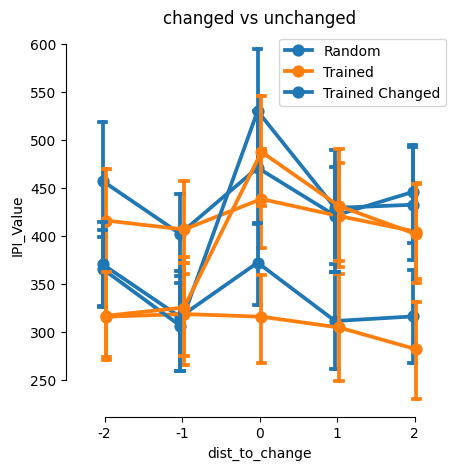

In [352]:
plt.figure(figsize=(5, 5))
cmap = cm.Pastel1
capsize = 5

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

lookback_window = 3

kwargs = {'changed': {'color': trained_pallet[1], 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

# session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_presses, axis = 1)
session3_blocks = utils.remove_error_trials_presses(session3_blocks)

session3_blocks['is_large_window'] = session3_blocks['windowSize'].apply(lambda x: x >= 3)



finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    
    if (flag_trained & flag_change):
        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos']) 
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
        label = 'changed'

    if (flag_trained & ~flag_change):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'unchanged'

    if (flag_rand):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'rand'

    data = data.groupby(['SubNum', 'dist_to_change', 'is_large_window']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data


    sns.pointplot(data = data, x = 'dist_to_change', y = 'IPI_Value', hue = 'is_large_window', dodge = True, capsize = 0.1)





# x = 3
# delta_x = 0.1
# y = 470
# delta_y = 100
# plt.plot([x + delta_x, x + 2 * delta_x, x + 2 * delta_x, x + delta_x], 
#          [y, y, y - delta_y, y - delta_y], color = 'black', alpha = 0.5, lw = 1)


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')


plt.title(f'changed vs unchanged')
plt.show()

*** IPI1 ***
                        Anova
                          F Value Num DF Den DF Pr > F
------------------------------------------------------
condition                 46.1127 1.0000 9.0000 0.0001
is_large_window            2.3169 1.0000 9.0000 0.1623
condition:is_large_window 11.1824 1.0000 9.0000 0.0086

*** IPI10 ***
                         Anova
                          F Value  Num DF Den DF Pr > F
-------------------------------------------------------
condition                 159.6844 1.0000 9.0000 0.0000
is_large_window            14.7065 1.0000 9.0000 0.0040
condition:is_large_window   4.2667 1.0000 9.0000 0.0689

*** IPI2 ***
                        Anova
                          F Value Num DF Den DF Pr > F
------------------------------------------------------
condition                 23.7857 1.0000 9.0000 0.0009
is_large_window            5.3326 1.0000 9.0000 0.0463
condition:is_large_window  0.6095 1.0000 9.0000 0.4550

*** IPI3 ***
                       

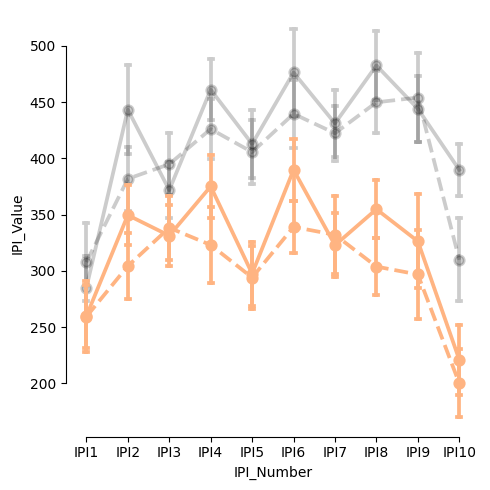

In [30]:

fig = plt.figure(figsize = (5,5))
trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()



# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

test_blocks = utils.remove_error_trials_presses(test_blocks)

test_blocks['is_large_window'] = test_blocks['windowSize'].apply(lambda x: x >= 3)


kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

kwargs_window = {True: '--', False: '-'}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'IPI_Number', 'is_large_window']).agg({
    'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    data = data.iloc[index_natsorted(data['IPI_Number'])].reset_index(drop=True)

    if label in ('rand', 'unchanged'):
        for is_large_window, data_window in data.groupby('is_large_window'):
            sns.pointplot(data = data_window, x = 'IPI_Number', y = 'IPI_Value',
                        errorbar = 'se', dodge = True, capsize = 0.1, **kwargs[label], linestyles = kwargs_window[is_large_window])


combined_data = pd.concat([finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])

for ipi in combined_data['IPI_Number'].unique():
    ipi_data = combined_data[combined_data['IPI_Number'] == ipi]
    print("***", ipi, "***")
    print(AnovaRM(data = ipi_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())


# print(AnovaRM(data = combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window', 'IPI_Number']).fit())



sns.despine(fig, trim = True)
fig.tight_layout()
# plt.savefig(path_figs + "Change_window_IPI.pdf", format = 'pdf')
plt.show()


319.5
401.25
IPI:  -6 TtestResult(statistic=-4.449860585832899, pvalue=0.001600518906482156, df=9)
285.5
338.0
IPI:  -5 TtestResult(statistic=-7.226595616922695, pvalue=4.939254531636967e-05, df=9)
321.0
417.5
IPI:  -4 TtestResult(statistic=-5.071149194977119, pvalue=0.0006708257509932073, df=9)
293.0
361.5
IPI:  -3 TtestResult(statistic=-7.758861303320385, pvalue=2.8242552943096453e-05, df=9)
333.5
427.75
IPI:  -2 TtestResult(statistic=-4.466449844954608, pvalue=0.0015626457272327888, df=9)
320.5
405.75
IPI:  -1 TtestResult(statistic=-3.7907353070686893, pvalue=0.004277818884476701, df=9)
IPI:  0 TtestResult(statistic=1.6552705162834882, pvalue=0.13225391013786283, df=9)
IPI:  1 TtestResult(statistic=0.5610078229969647, pvalue=0.5884852101611623, df=9)
IPI:  2 TtestResult(statistic=-0.18441906643360348, pvalue=0.8577732500242538, df=9)
IPI:  3 TtestResult(statistic=-0.1386366539070143, pvalue=0.8927897596879599, df=9)
IPI:  4 TtestResult(statistic=0.7438508728484924, pvalue=0.47593720

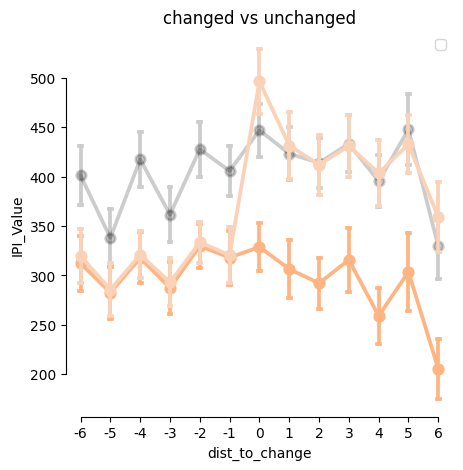

In [341]:
plt.figure(figsize=(5, 5))
cmap = cm.Pastel1
capsize = 5

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

lookback_window = 7

kwargs = {'changed': {'color': trained_pallet[1], 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

# session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_presses, axis = 1)
session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    
    if (flag_trained & flag_change):
        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos']) 
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
        label = 'changed'

    if (flag_trained & ~flag_change):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'unchanged'

    if (flag_rand):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'rand'

    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data


    sns.pointplot(data = data, x = 'dist_to_change', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1, **kwargs[label])



#Statistical Signficance Tests
merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'dist_to_change'], suffixes=('_changed', '_unchanged'))
merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'dist_to_change'])
merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

for IPI in merged_df['dist_to_change'].unique():
    IPI_data = merged_df[merged_df['dist_to_change'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
    ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
    ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])

    
    # Add significance symbols just above the error bars
    changed_mean = IPI_data['IPI_Value_changed'].mean()
    changed_std = IPI_data['IPI_Value_changed'].std()
    unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
    unchanged_std = IPI_data['IPI_Value_unchanged'].std()
    rand_mean = IPI_data['IPI_Value_rand'].mean()
    rand_std = IPI_data['IPI_Value_rand'].std()

    y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
    y_pos_unchanged = unchanged_mean - unchanged_std 
    y_pos_rand = rand_mean - rand_std

    y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

    # if ttest_changed_vs_unchanged.pvalue < 0.05:
        # plt.text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')
        # plt.text(IPI, (changed_mean + unchanged_mean)/2, '*', ha='center', va='bottom', color='C1')

    if ttest_changed_vs_rand.pvalue < 0.05:
    #     plt.text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')
        print(changed_mean)
        print(rand_mean)
        # plt.text(IPI + 2, (changed_mean + rand_mean)/2, '*', ha='center', va='bottom', color='C1')


    # if ttest_unchanged_vs_rand.pvalue < 0.05:
    #     plt.text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)

    print('IPI: ', IPI, ttest_changed_vs_rand)

# x = 3
# delta_x = 0.1
# y = 470
# delta_y = 100
# plt.plot([x + delta_x, x + 2 * delta_x, x + 2 * delta_x, x + delta_x], 
#          [y, y, y - delta_y, y - delta_y], color = 'black', alpha = 0.5, lw = 1)


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')


plt.title(f'changed vs unchanged')
plt.show()

IPI:  IPI1 TtestResult(statistic=-4.668692168426596, pvalue=0.001170751798937856, df=9)
IPI:  IPI10 TtestResult(statistic=0.3452409100170155, pvalue=0.7378449191920737, df=9)
IPI:  IPI2 TtestResult(statistic=-4.569413956308064, pvalue=0.0013480229344327605, df=9)
IPI:  IPI3 TtestResult(statistic=-2.241166925676995, pvalue=0.051744543559342104, df=9)
IPI:  IPI4 TtestResult(statistic=-4.463838493402428, pvalue=0.0015685432960461016, df=9)
IPI:  IPI5 TtestResult(statistic=-6.196482918056094, pvalue=0.00015953814506435178, df=9)
IPI:  IPI6 TtestResult(statistic=1.5680159017814972, pvalue=0.15132168816340782, df=9)
IPI:  IPI7 TtestResult(statistic=-0.04043524930261955, pvalue=0.9686289217330561, df=9)
IPI:  IPI8 TtestResult(statistic=0.8598623768846114, pvalue=0.4121830010553055, df=9)
IPI:  IPI9 TtestResult(statistic=0.9119387440855415, pvalue=0.3855764871644308, df=9)


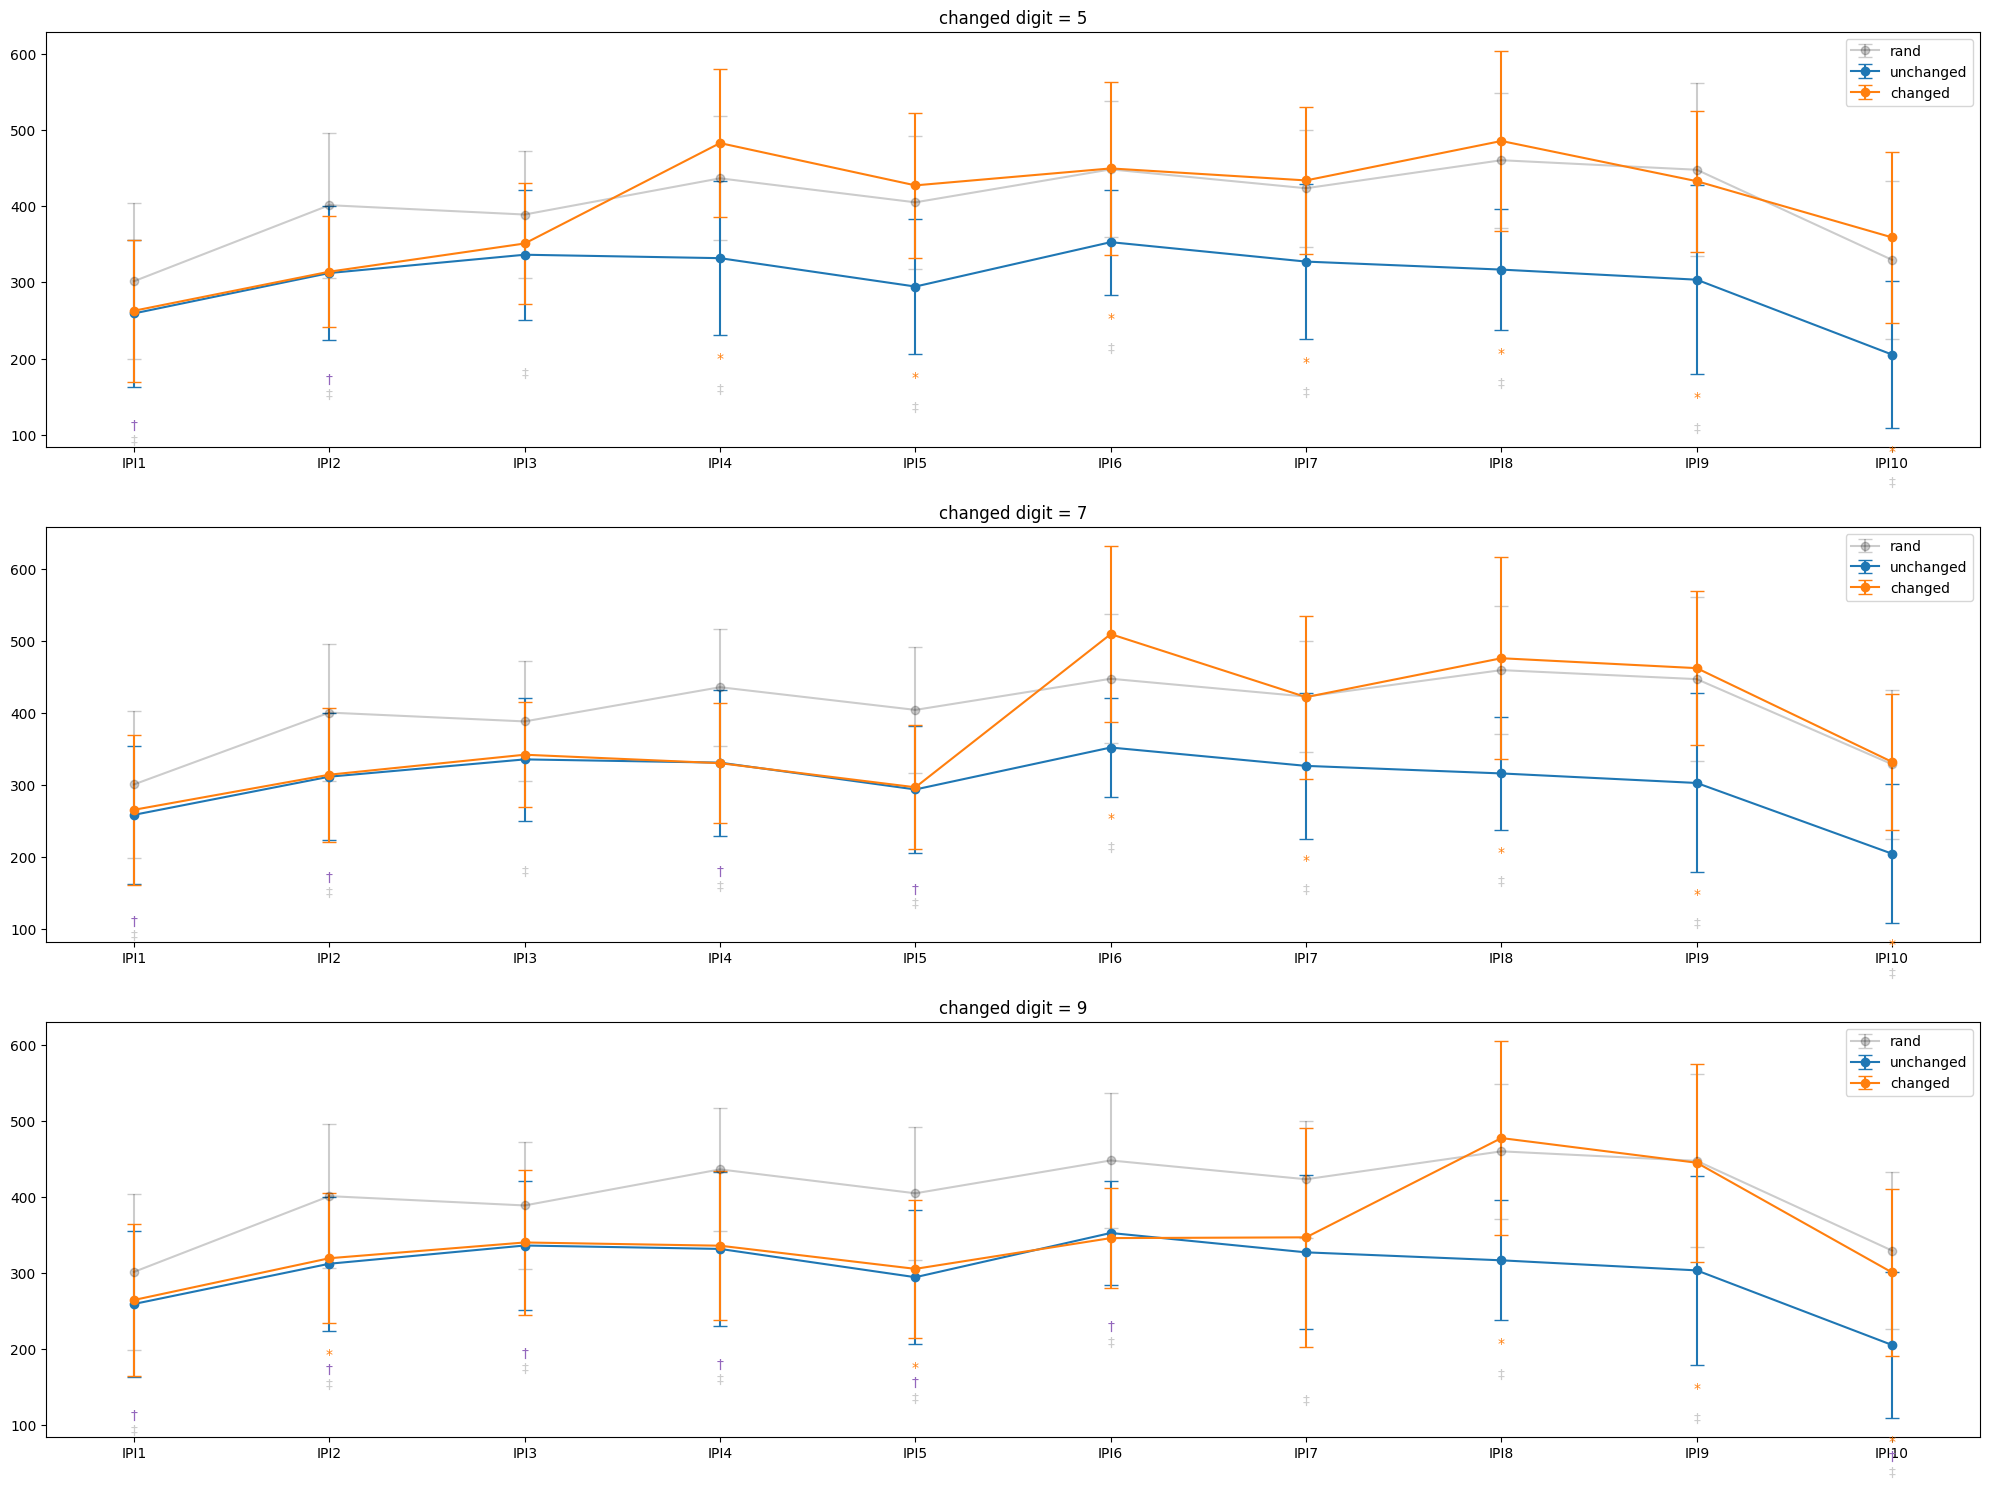

In [35]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}

for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], 
                          label = label, capsize = capsize, **kwargs[label], fmt = '-o')



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 6):
            print('IPI: ', IPI, ttest_changed_vs_rand)



    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')
    plt.tight_layout()

    # plt.savefig(path_figs + "IPI_Pattern_Main.pdf", format = 'pdf')
    

In [107]:
# fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
# cmap = cm.Pastel1
# capsize = 5

# kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


# session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

# # session3_blocks = utils.remove_error_trials_presses(session3_blocks)

# session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_presses, axis = 1)

# finger_aggs = {}

# for idx, change in enumerate(digit_change):
#     for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
#         if (flag_trained & flag_change):

#             data = data[data['digitChangePos'] == change]

#             label = 'changed'

#         if (flag_trained & ~flag_change):

#             label = 'unchanged'

#         if (flag_rand):

#             label = 'rand'


#         data = data.groupby(['SubNum', 'IPI_Number']).agg({
#             'IPI_Value': 'median'
#         }).reset_index()

#         finger_aggs[label] = data

#         finger_agg = data.groupby(['IPI_Number']).agg({
#             'IPI_Value': ['mean', 'std']
#         }).reset_index()

#         finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
#         axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], 
#                           label = label, capsize = capsize, **kwargs[label], fmt = '-o')



#     #Statistical Signficance Tests
#     merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
#     merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
#     merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

#     for IPI in merged_df['IPI_Number'].unique():
#         IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
#         ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
#         ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
#         ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
#         # Add significance symbols just above the error bars
#         changed_mean = IPI_data['IPI_Value_changed'].mean()
#         changed_std = IPI_data['IPI_Value_changed'].std()
#         unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
#         unchanged_std = IPI_data['IPI_Value_unchanged'].std()
#         rand_mean = IPI_data['IPI_Value_rand'].mean()
#         rand_std = IPI_data['IPI_Value_rand'].std()

#         y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
#         y_pos_unchanged = unchanged_mean - unchanged_std 
#         y_pos_rand = rand_mean - rand_std

#         y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

#         if ttest_changed_vs_unchanged.pvalue < 0.05:
#             axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

#         if ttest_changed_vs_rand.pvalue < 0.05:
#             axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

#         if ttest_unchanged_vs_rand.pvalue < 0.05:
#             axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


#         if(change == 6):
#             print('IPI: ', IPI, ttest_changed_vs_rand)



    
#     axs[idx].legend()

#     axs[idx].set_title(f'changed digit = {change + 1}')
#     plt.tight_layout()

#     # plt.savefig(path_figs + "IPI_Pattern_Main.pdf", format = 'pdf')
    

rand  3 vs 11: p_value =  0.10745352596290757
unchanged  3 vs 11: p_value =  0.6199286566770452
changed  3 vs 11: p_value =  0.1800530252179282
All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            63.1919 2.0000 18.0000 0.0000
windowSize           16.9640 3.0000 27.0000 0.0000
condition:windowSize  1.1862 6.0000 54.0000 0.3276

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            64.5805 1.0000  9.0000 0.0000
windowSize            9.0681 3.0000 27.0000 0.0003
condition:windowSize  1.8341 3.0000 27.0000 0.1648

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition             0.2774 1.0000  9.0000 0.6111
windowSize            8.9190 3.0000 27.0000 0.0003
cond

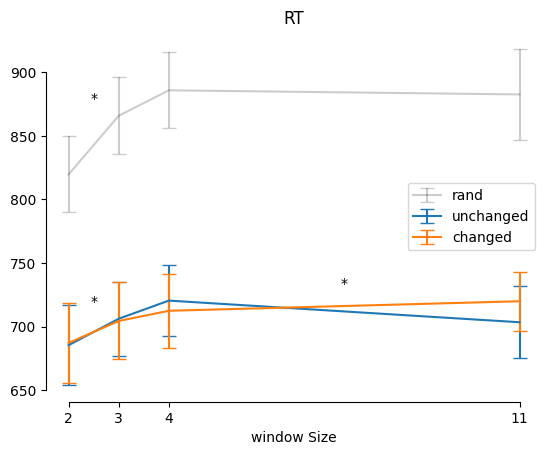

In [36]:
session3_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'RT': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data

        
    data_agged = data.groupby('windowSize').agg({
        'RT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['RT']['mean'], yerr = data_agged['RT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['RT']['mean']
    sems = data_agged['RT']['sem']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['RT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['RT'], 
        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


    t_stat, p_value = stats.ttest_rel(
        data[data['windowSize'] == 3]['RT'], 
        data[data['windowSize'] == 11]['RT']
    )
    print(label, " 3 vs 11: p_value = ",  p_value)
    if p_value < 0.05:
            plt.text((3 + 11) / 2, max(means[1] + sems[1], means[3] + sems[3]) + 10, '*', color='black', ha='center')


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='RT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='RT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='RT', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('RT')
plt.legend()
plt.xlabel('window Size')
sns.despine(trim = True)
# plt.savefig(path_figs + "RT.pdf", format = 'pdf')
plt.show()




rand  3 vs 11: p_value =  0.7988171703978746
unchanged  3 vs 11: p_value =  0.15291635686078964
changed  3 vs 11: p_value =  0.9961830187026082
All Three: 
                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
condition            200.4285 2.0000 18.0000 0.0000
windowSize             5.0306 3.0000 27.0000 0.0067
condition:windowSize   0.4093 6.0000 54.0000 0.8697

unchanged_rand: 
                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
condition            280.8369 1.0000  9.0000 0.0000
windowSize             5.5255 3.0000 27.0000 0.0043
condition:windowSize   0.4838 3.0000 27.0000 0.6963

changed_unchanged: 
                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
condition            137.2589 1.0000  9.0000 0.0000
windowSize             2.9597 3.0000 27

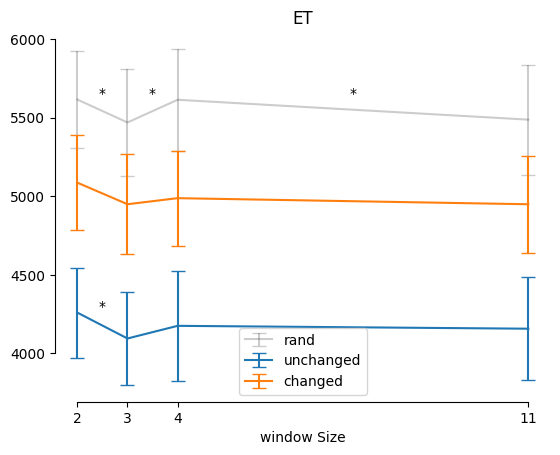

In [63]:
session3_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data

        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']
    sems = data_agged['norm_MT']['sem']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 
        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')
            # print("condition:",label, windowSizes[i], windowSizes[i + 1], p_value)


    t_stat, p_value = stats.ttest_rel(
        data[data['windowSize'] == 3]['norm_MT'], 
        data[data['windowSize'] == 11]['norm_MT']
    )
    print(label, " 3 vs 11: p_value = ",  p_value)
    if p_value < 0.05:
            plt.text((3 + 11) / 2, max(means[1] + sems[1], means[3] + sems[3]) + 10, '*', color='black', ha='center')


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
sns.despine(trim = True)
# plt.savefig(path_figs + "ET.pdf", format = 'pdf')
plt.show()




rand  3 vs 11: p_value =  0.4973059378839261
unchanged  3 vs 11: p_value =  0.06666314098912697
changed  3 vs 11: p_value =  0.8894886794998915
All Three: 
                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
condition            176.2587 2.0000 18.0000 0.0000
windowSize             7.8409 3.0000 27.0000 0.0006
condition:windowSize   0.5805 6.0000 54.0000 0.7442

unchanged_rand: 
                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
condition            258.9110 1.0000  9.0000 0.0000
windowSize             7.6794 3.0000 27.0000 0.0007
condition:windowSize   0.8830 3.0000 27.0000 0.4623

changed_unchanged: 
                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
condition            144.9207 1.0000  9.0000 0.0000
windowSize             5.1998 3.0000 27

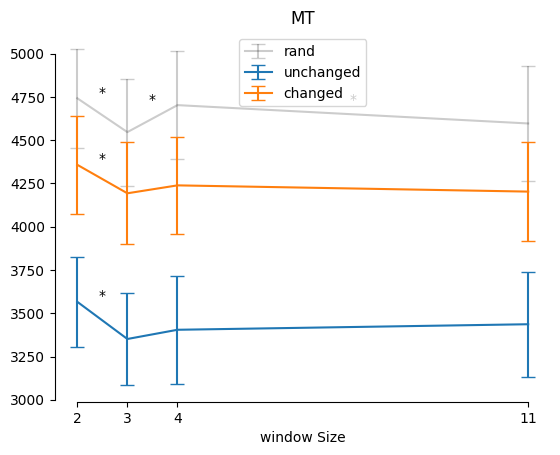

In [68]:
session3_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'ET': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data

        
    data_agged = data.groupby('windowSize').agg({
        'ET': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['ET']['mean'], yerr = data_agged['ET']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['ET']['mean']
    sems = data_agged['ET']['sem']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['ET'], 
            data[data['windowSize'] == windowSizes[i + 1]]['ET'], 
        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['ET']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')
            # print("condition:",label, windowSizes[i], windowSizes[i + 1], p_value)


    t_stat, p_value = stats.ttest_rel(
        data[data['windowSize'] == 3]['ET'], 
        data[data['windowSize'] == 11]['ET']
    )
    print(label, " 3 vs 11: p_value = ",  p_value)
    if p_value < 0.05:
            plt.text((3 + 11) / 2, max(means[1] + sems[1], means[3] + sems[3]) + 10, '*', color='black', ha='center')


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='ET', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='ET', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='ET', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('MT')
plt.legend()
plt.xlabel('window Size')
sns.despine(trim = True)
# plt.savefig(path_figs + "ET.pdf", format = 'pdf')
plt.show()




In [17]:
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [19]:
sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

[(0.9523413423497763, 0.941516248083272, 0.9366859392509898),
 (0.9762641195232219, 0.8232372732668476, 0.7224079068457255),
 (1.0, 0.7058823529411765, 0.5098039215686274)]

rand  2 vs 3+ : p_value =  0.014948188813738127
unchanged  2 vs 3+ : p_value =  0.023019640956511364
changed  2 vs 3+ : p_value =  0.014181288670124553
All Three: 
                          Anova
                          F Value  Num DF  Den DF Pr > F
--------------------------------------------------------
condition                 175.7754 2.0000 18.0000 0.0000
is_large_window            14.6567 1.0000  9.0000 0.0040
condition:is_large_window   0.1724 2.0000 18.0000 0.8430

unchanged_rand: 
                          Anova
                          F Value  Num DF Den DF Pr > F
-------------------------------------------------------
condition                 291.2307 1.0000 9.0000 0.0000
is_large_window            13.1263 1.0000 9.0000 0.0055
condition:is_large_window   0.2592 1.0000 9.0000 0.6229

changed_unchanged: 
                          Anova
                          F Value  Num DF Den DF Pr > F
-------------------------------------------------------
condition               

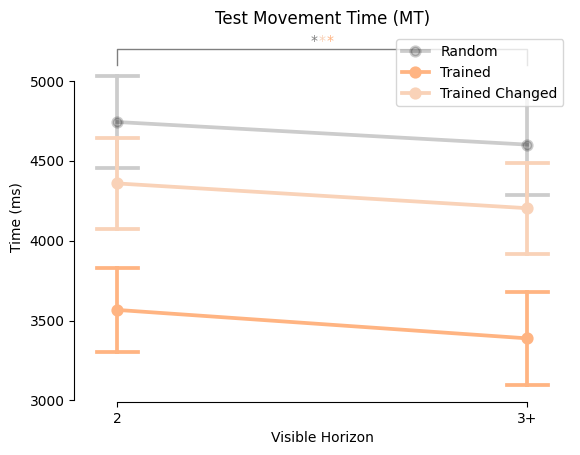

In [9]:
trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
session3_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

session3_blocks['is_large_window'] = session3_blocks['windowSize'].apply(lambda x: x >= 3)

kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'is_large_window']).agg({
    'ET': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data


    sns.pointplot(data=data, x='is_large_window', y='ET', errorbar='se', dodge=True, label = label, capsize=0.1, **kwargs[label])



    t_stat, p_value = stats.ttest_rel(
        data[data['is_large_window'] == False]['ET'],
        data[data['is_large_window'] == True]['ET']
    )
    print(label, " 2 vs 3+ : p_value = ",  p_value)


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='ET', subject='SubNum', within=['condition', 'is_large_window']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='ET', subject='SubNum', within=['condition', 'is_large_window']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='ET', subject='SubNum', within=['condition', 'is_large_window']).fit())


# plot significance bar on the plot
h = 100
y = 5100
plt.plot([0,0, 1, 1], [y, y + h, y + h, y], color = 'black', alpha = 0.5, lw = 1)

#three stars with corresponding colors for all conditions on top of the bar
delta_x = 0.02
plt.text(0.5 - delta_x, y + h + 10, '*', ha='center', va='bottom', color = 'black', alpha = 0.5, size = 10)
plt.text(0.5, y + h + 10, '*', ha='center', va='bottom', color = trained_pallet[1], size = 10)
plt.text(0.5 + delta_x, y + h + 10, '*', ha='center', va='bottom', color = trained_pallet[2], size = 10)


plt.xticks([0,1], ['2', '3+'])
plt.title('Test Movement Time (MT)')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

plt.xlabel('Visible Horizon')
plt.ylabel('Time (ms)')
sns.despine(trim = True)
# plt.savefig(path_figs + "MT_test.pdf", format = 'pdf')
plt.show()


Horizon effect on late half sequence production speed:

rand  2 vs 3+ : p_value =  0.004314821407856282
unchanged  2 vs 3+ : p_value =  0.004277392636696303
changed  2 vs 3+ : p_value =  0.0259433799055254
All Three: 
                          Anova
                          F Value  Num DF  Den DF Pr > F
--------------------------------------------------------
condition                 260.5153 2.0000 18.0000 0.0000
is_large_window            61.3855 1.0000  9.0000 0.0000
condition:is_large_window   0.0047 2.0000 18.0000 0.9953

unchanged_rand: 
                          Anova
                          F Value  Num DF Den DF Pr > F
-------------------------------------------------------
condition                 413.5964 1.0000 9.0000 0.0000
is_large_window            23.1536 1.0000 9.0000 0.0010
condition:is_large_window   0.0183 1.0000 9.0000 0.8953

changed_unchanged: 
                          Anova
                          F Value  Num DF Den DF Pr > F
-------------------------------------------------------
condition                 

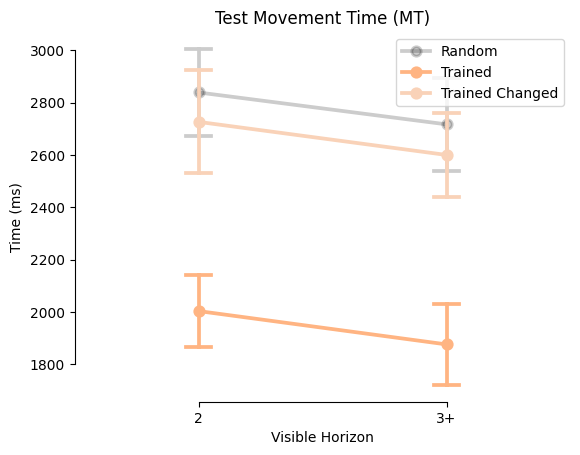

In [52]:
trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

session3_blocks = utils.remove_error_trials_presses(session3_blocks)

late_IPI_N = 6

session3_blocks = session3_blocks[session3_blocks['N'] >= late_IPI_N]

session3_blocks['is_large_window'] = session3_blocks['windowSize'].apply(lambda x: x >= 3)



kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'


    data = data.groupby(['SubNum', 'BN', 'TN', 'is_large_window']).agg({
        'IPI_Value': 'sum'
    }).reset_index()

    data = data.groupby(['SubNum', 'is_large_window']).agg({
    'IPI_Value': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data


    sns.pointplot(data=data, x='is_large_window', y='IPI_Value', errorbar='se', dodge=True, label = label, capsize=0.1, **kwargs[label])



    t_stat, p_value = stats.ttest_rel(
        data[data['is_large_window'] == False]['IPI_Value'],
        data[data['is_large_window'] == True]['IPI_Value']
    )
    print(label, " 2 vs 3+ : p_value = ",  p_value)


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())


# # plot significance bar on the plot
# h = 100
# y = 5100
# plt.plot([0,0, 1, 1], [y, y + h, y + h, y], color = 'black', alpha = 0.5, lw = 1)

# #three stars with corresponding colors for all conditions on top of the bar
# delta_x = 0.02
# plt.text(0.5 - delta_x, y + h + 10, '*', ha='center', va='bottom', color = 'black', alpha = 0.5, size = 10)
# plt.text(0.5, y + h + 10, '*', ha='center', va='bottom', color = trained_pallet[1], size = 10)
# plt.text(0.5 + delta_x, y + h + 10, '*', ha='center', va='bottom', color = trained_pallet[2], size = 10)


plt.xticks([0,1], ['2', '3+'])
plt.title('Test Movement Time (MT)')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

plt.xlabel('Visible Horizon')
plt.ylabel('Time (ms)')
sns.despine(trim = True)
# plt.savefig(path_figs + "MT_test.pdf", format = 'pdf')
plt.show()


unchanged vs rand: p_value =  0.6229367579696601


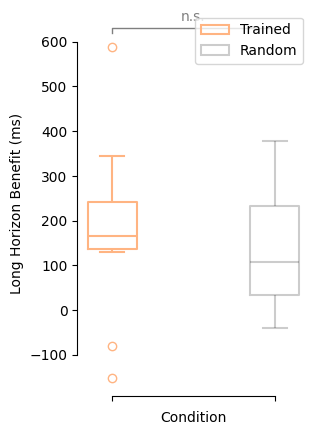

In [234]:
plt.figure(figsize=(3, 5))
trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
session3_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

session3_blocks['is_large_window'] = session3_blocks['windowSize'].apply(lambda x: x >= 3)

kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'is_large_window']).agg({
    'ET': lambda x: np.percentile(x, 50)
    }).reset_index()

    # calculate difference between 2 and 3+ window sizes for each subject
    data = data.pivot(index='SubNum', columns='is_large_window', values='ET').reset_index()
    data['benefit'] = data[False] - data[True]
    data.drop(columns=[False, True], inplace=True)


    finger_aggs[label] = data

    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

sns.boxplot(data=combined_data, x='condition', y='benefit', fill = False, width = 0.3, dodge = False,
            palette=[trained_pallet[2], (0, 0, 0, 0.2)], gap = 0, hue = 'condition', legend = True)


ttest, p_value = stats.ttest_rel(
    combined_data[combined_data['condition'] == 'unchanged']['benefit'],
    combined_data[combined_data['condition'] == 'rand']['benefit']
)
print("unchanged vs rand: p_value = ",  p_value)

# plot significance bar on the plot
h = 10
y = 620
plt.plot([0,0, 1, 1], [y, y + h, y + h, y], color = 'black', alpha = 0.5, lw = 1)
plt.text(0.5, y + h + 10, 'n.s.', ha='center', va='bottom', color = 'black', alpha = 0.5, size = 10)

plt.xticks([0,1], ['', ''])

# label legends
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random']
plt.legend(handles, labels, loc='upper right')


plt.xlabel('Condition')
plt.ylabel('Long Horizon Benefit (ms)')
sns.despine(trim = True)
plt.savefig(path_figs + "Horizon_benefit.pdf", format = 'pdf')
plt.show()


In [ ]:
# combined_data.to_csv(utils.path_misc + 'benefit.csv', index = False)

In [227]:
combined_data = pd.concat([pd.read_csv(utils.path_misc + 'benefit_SDI1.csv'), 
          pd.read_csv(utils.path_misc + 'benefit.csv')])

In [230]:
ttest, p_value = stats.ttest_rel(
    combined_data[combined_data['condition'] == 'unchanged']['benefit'],
    combined_data[combined_data['condition'] == 'rand']['benefit']
)
print("unchanged vs rand: p_value = ",  p_value)

unchanged vs rand: p_value =  0.36528313677662816


************************** IPI Change + 0 **************************************
All Three: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            19.7601 2.0000 18.0000 0.0000
windowSize            5.2658 3.0000 27.0000 0.0054
condition:windowSize  0.9709 6.0000 54.0000 0.4538

unchanged_rand: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            23.9136 1.0000  9.0000 0.0009
windowSize            5.2483 3.0000 27.0000 0.0055
condition:windowSize  3.9886 3.0000 27.0000 0.0179

changed_unchanged: 
                       Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
condition            31.4604 1.0000  9.0000 0.0003
windowSize            4.9639 3.0000 27.0000 0.0072
condition:windowSize  0.9571 3.0000 27.0000 0.4272

changed_rand: 


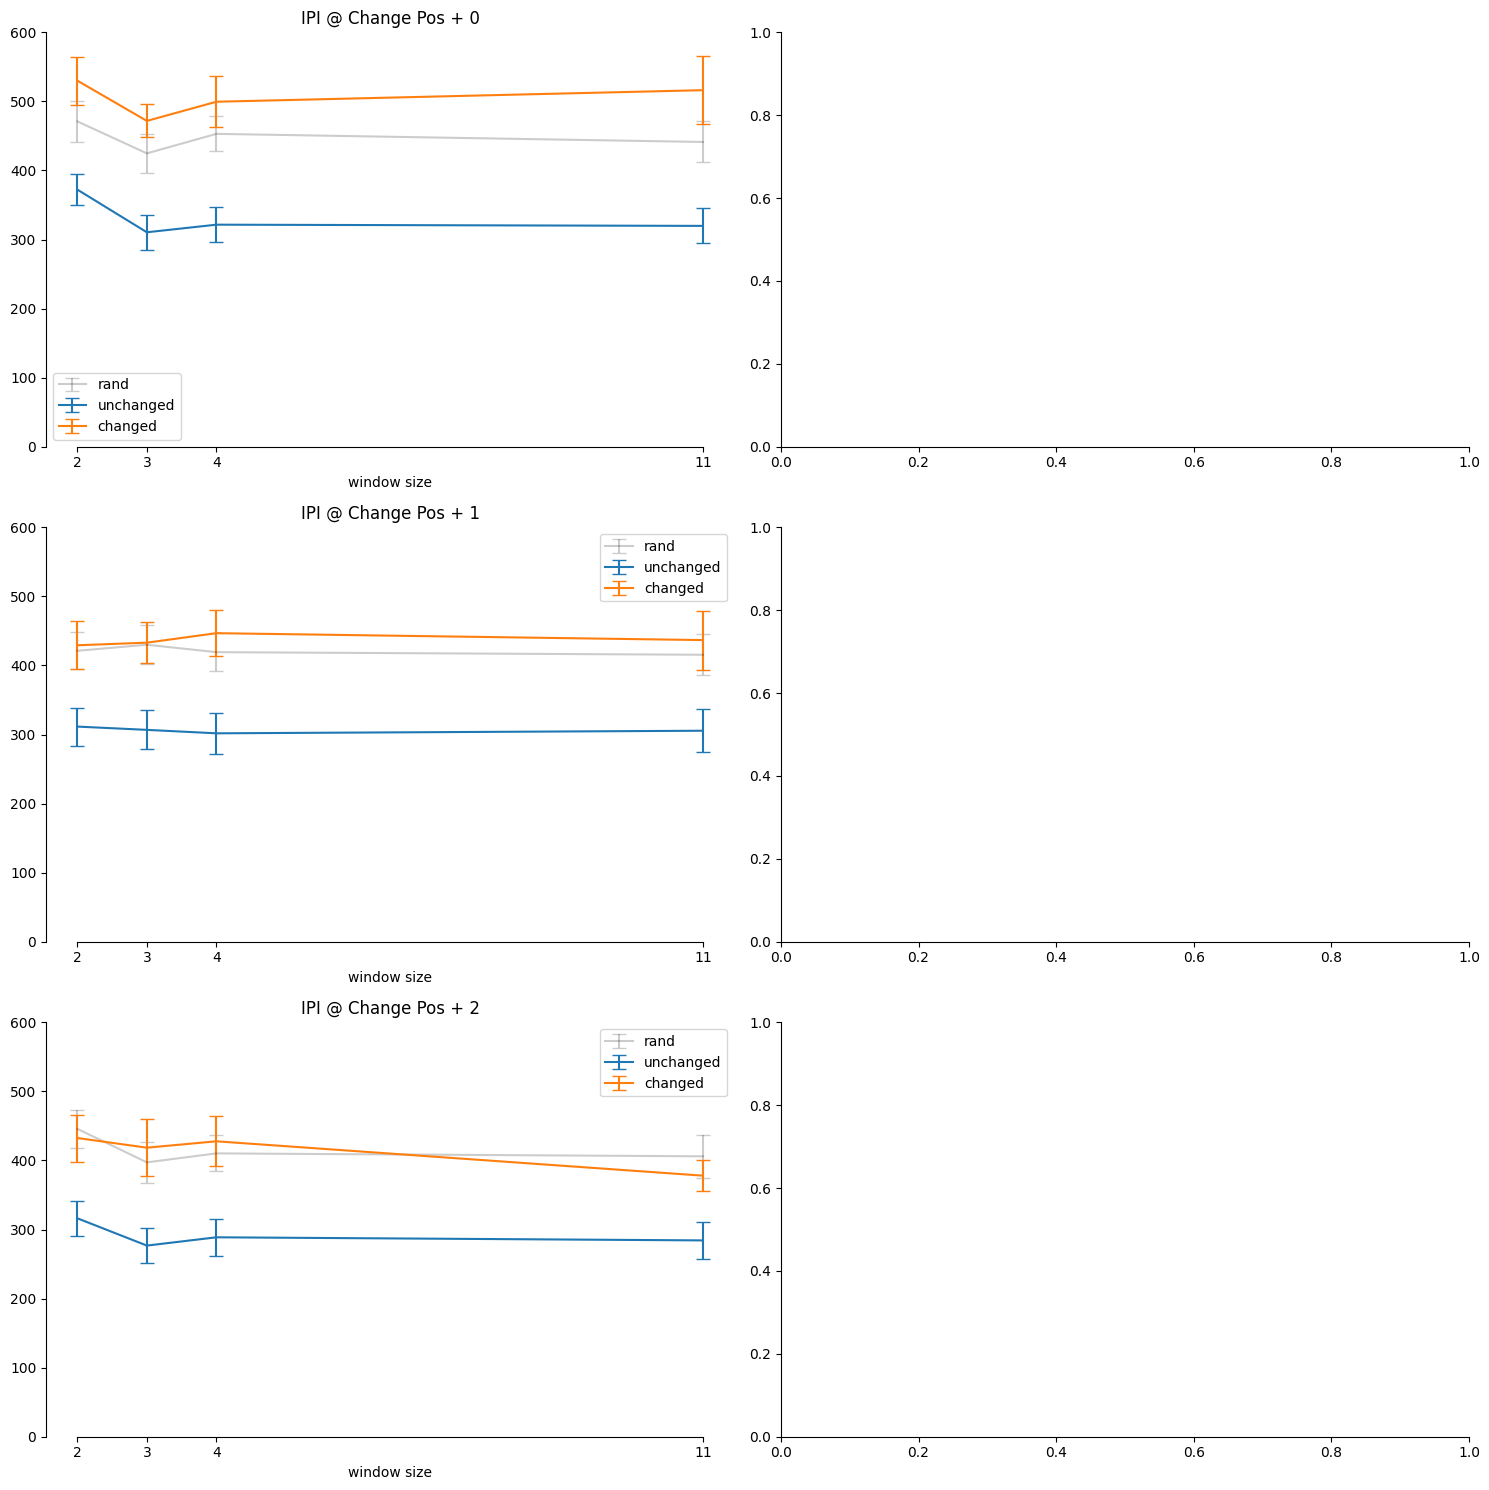

In [100]:
lookahead_window = 3

fig, axs = plt.subplots(nrows=lookahead_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()


# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for lookahead in range(lookahead_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in digit_change])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    # for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in [4,6]])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[(data['digitChangePos'] + 1 + lookahead) == (data['N'])]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'windowSize']).agg({
        'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data
  
        data_agged = data.groupby('windowSize').agg({
            'IPI_Value': ['mean', 'sem']
        }).reset_index()

        axs[lookahead, 0].errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

        means = data_agged['IPI_Value']['mean']

        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        axs[lookahead, 0].set_title(f'IPI @ Change Pos + {lookahead}')
        axs[lookahead, 0].set_xlabel('window size')
        axs[lookahead, 0].set_xticks(data_agged['windowSize'])
        axs[lookahead, 0].legend()
        axs[lookahead, 0].set_ylim([0, 600])

        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    


    print(f"************************** IPI Change + {lookahead} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("changed_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['rand', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())


    if (lookahead == 0):
        for window in windowSizes:
            ttest_changed_vs_rand = stats.ttest_rel(
                finger_aggs['changed'][finger_aggs['changed']['windowSize'] == window]['IPI_Value'], 
                finger_aggs['rand'][finger_aggs['rand']['windowSize'] == window]['IPI_Value']
            )
            print(f"changed vs rand: window {window} : {ttest_changed_vs_rand}")



    # merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    # merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    # merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    # merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    # data_agged = merged_df.groupby('windowSize').agg({
    #         'rel': ['mean', 'sem']
    #     }).reset_index()
     
    # axs[lookahead, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    # axs[lookahead, 1].set_title(f'IPI @ Change Pos + {lookahead}')
    # axs[lookahead, 1].set_xticks(data_agged['windowSize'])
    # axs[lookahead, 1].legend()



sns.despine(fig, trim = True)
fig.tight_layout()
# plt.savefig(path_figs + "change_after_window_IPI.pdf", format = 'pdf')
plt.show()


************************** IPI Change + 0 **************************************
All Three: 
                          Anova
                          F Value Num DF  Den DF Pr > F
-------------------------------------------------------
condition                 18.3716 2.0000 18.0000 0.0000
is_large_window            9.0013 1.0000  9.0000 0.0150
condition:is_large_window  1.5289 2.0000 18.0000 0.2436

unchanged_rand: 
                         Anova
                          F Value Num DF Den DF Pr > F
------------------------------------------------------
condition                 22.6799 1.0000 9.0000 0.0010
is_large_window            5.5015 1.0000 9.0000 0.0436
condition:is_large_window  9.1418 1.0000 9.0000 0.0144

changed_unchanged: 
                         Anova
                          F Value Num DF Den DF Pr > F
------------------------------------------------------
condition                 30.7230 1.0000 9.0000 0.0004
is_large_window           13.8204 1.0000 9.0000 0.0048

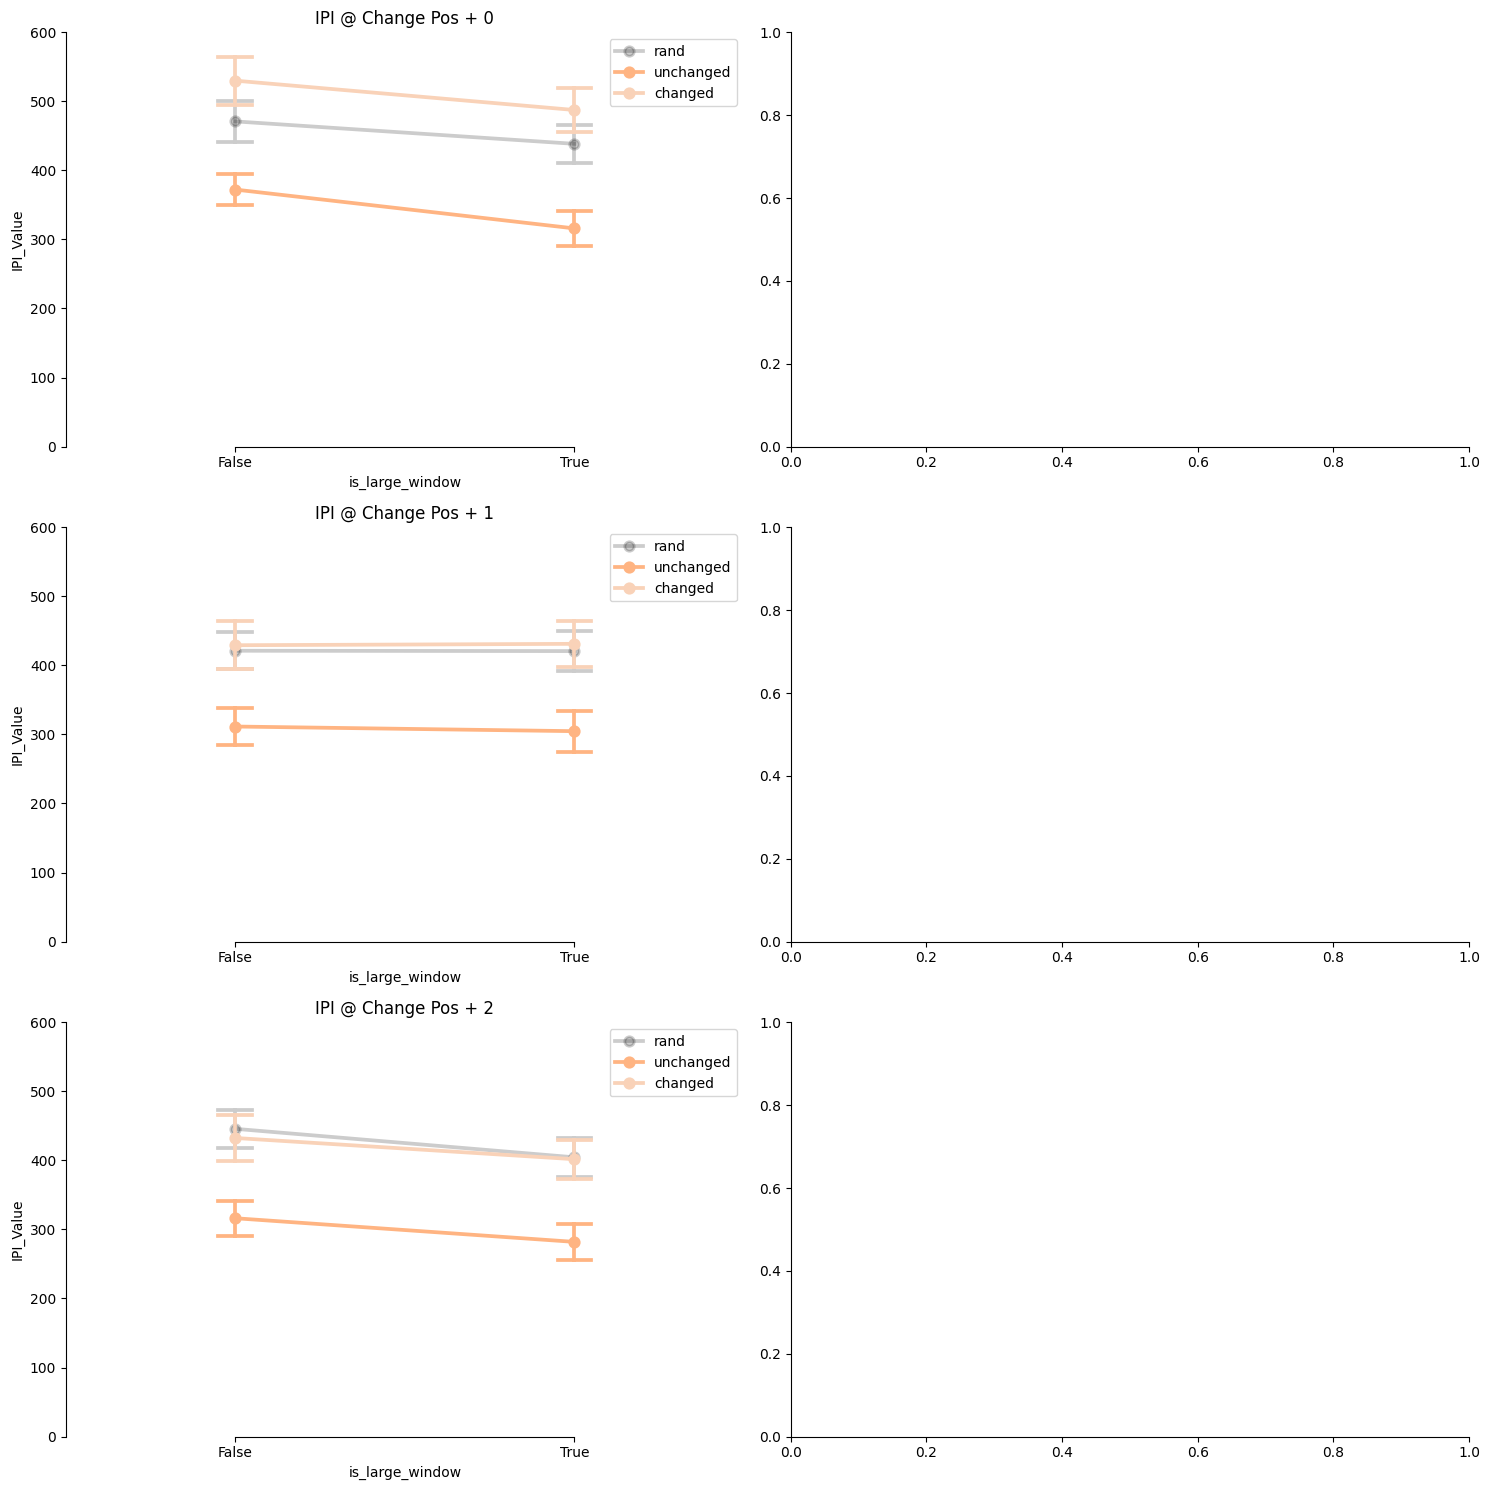

In [349]:
lookahead_window = 3

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

fig, axs = plt.subplots(nrows=lookahead_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()


# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

test_blocks = utils.remove_error_trials_presses(test_blocks)

test_blocks['is_large_window'] = test_blocks['windowSize'].apply(lambda x: x >= 3)


kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for lookahead in range(lookahead_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in digit_change])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    # for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in [4,6]])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[(data['digitChangePos'] + 1 + lookahead) == (data['N'])]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'is_large_window']).agg({
        'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data
  

        sns.pointplot(data = data, x = 'is_large_window', y = 'IPI_Value', errorbar = 'se', dodge = True, label = label, capsize = 0.1, **kwargs[label], ax = axs[lookahead, 0])

        axs[lookahead, 0].set_title(f'IPI @ Change Pos + {lookahead}')
        axs[lookahead, 0].set_ylim([0, 600])

        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    


    print(f"************************** IPI Change + {lookahead} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
    print("changed_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['rand', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())


    if (lookahead == 0):
        for window in [False, True]:
            ttest_changed_vs_rand = stats.ttest_rel(
                finger_aggs['changed'][finger_aggs['changed']['is_large_window'] == window]['IPI_Value'], 
                finger_aggs['rand'][finger_aggs['rand']['is_large_window'] == window]['IPI_Value']
            )
            print(f"changed vs rand: window {window} : {ttest_changed_vs_rand}")



    # merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    # merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    # merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    # merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    # data_agged = merged_df.groupby('windowSize').agg({
    #         'rel': ['mean', 'sem']
    #     }).reset_index()
     
    # axs[lookahead, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    # axs[lookahead, 1].set_title(f'IPI @ Change Pos + {lookahead}')
    # axs[lookahead, 1].set_xticks(data_agged['windowSize'])
    # axs[lookahead, 1].legend()



sns.despine(fig, trim = True)
fig.tight_layout()
# plt.savefig(path_figs + "change_after_window_IPI.pdf", format = 'pdf')
plt.show()


In [108]:
# lookahead_window = 3

# fig, axs = plt.subplots(nrows=lookahead_window, ncols=2 , figsize= (15,15))

# test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()


# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

# # test_blocks = utils.remove_error_trials_presses(test_blocks)

# kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

# for lookahead in range(lookahead_window):

#     finger_aggs = {}

#     for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in digit_change])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
#     # for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in [4,6]])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

#         if (flag_trained & flag_change):
#             data = data[(data['digitChangePos'] + 1 + lookahead) == (data['N'])]
#             label = 'changed'

#         if(flag_trained & ~flag_change):
#             label = 'unchanged'

#         if (flag_rand):
#             label = 'rand'

#         data = data.groupby(['SubNum', 'windowSize']).agg({
#         'IPI_Value': 'median'
#         }).reset_index()

#         finger_aggs[label] = data
  
#         data_agged = data.groupby('windowSize').agg({
#             'IPI_Value': ['mean', 'sem']
#         }).reset_index()

#         axs[lookahead, 0].errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

#         means = data_agged['IPI_Value']['mean']

#         # for i in range(len(windowSizes) - 1):
#         #     t_stat, p_value = stats.ttest_rel(
#         #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
#         #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

#         #     )
#         #     if p_value < 0.05:
#         #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
#         #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
#         #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


#         axs[lookahead, 0].set_title(f'IPI @ Change Pos + {lookahead}')
#         axs[lookahead, 0].set_xlabel('window size')
#         axs[lookahead, 0].set_xticks(data_agged['windowSize'])
#         axs[lookahead, 0].legend()
#         axs[lookahead, 0].set_ylim([0, 700])

#         # Combine all data into a single DataFrame
#     combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
#                             finger_aggs['unchanged'].assign(condition='unchanged'),
#                             finger_aggs['rand'].assign(condition='rand')])
    


#     print(f"************************** IPI Change + {lookahead} **************************************")

#     print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
#     print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
#     print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
#     print("changed_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['rand', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())


#     if (lookahead == 0):
#         for window in windowSizes:
#             ttest_changed_vs_rand = stats.ttest_rel(
#                 finger_aggs['changed'][finger_aggs['changed']['windowSize'] == window]['IPI_Value'], 
#                 finger_aggs['rand'][finger_aggs['rand']['windowSize'] == window]['IPI_Value']
#             )
#             print(f"changed vs rand: window {window} : {ttest_changed_vs_rand}")



#     # merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
#     # merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
#     # merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
#     # merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

#     # data_agged = merged_df.groupby('windowSize').agg({
#     #         'rel': ['mean', 'sem']
#     #     }).reset_index()
     
#     # axs[lookahead, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
#     # axs[lookahead, 1].set_title(f'IPI @ Change Pos + {lookahead}')
#     # axs[lookahead, 1].set_xticks(data_agged['windowSize'])
#     # axs[lookahead, 1].legend()



# sns.despine(fig, trim = True)
# fig.tight_layout()
# # plt.savefig(path_figs + "change_after_window_IPI.pdf", format = 'pdf')
# plt.show()


************************** IPI Change - 0 **************************************
All Three: 
                          Anova
                          F Value Num DF  Den DF Pr > F
-------------------------------------------------------
condition                 18.3716 2.0000 18.0000 0.0000
is_large_window            9.0013 1.0000  9.0000 0.0150
condition:is_large_window  1.5289 2.0000 18.0000 0.2436

unchanged_rand: 
                         Anova
                          F Value Num DF Den DF Pr > F
------------------------------------------------------
condition                 22.6799 1.0000 9.0000 0.0010
is_large_window            5.5015 1.0000 9.0000 0.0436
condition:is_large_window  9.1418 1.0000 9.0000 0.0144

changed_unchanged: 
                         Anova
                          F Value Num DF Den DF Pr > F
------------------------------------------------------
condition                 30.7230 1.0000 9.0000 0.0004
is_large_window           13.8204 1.0000 9.0000 0.0048

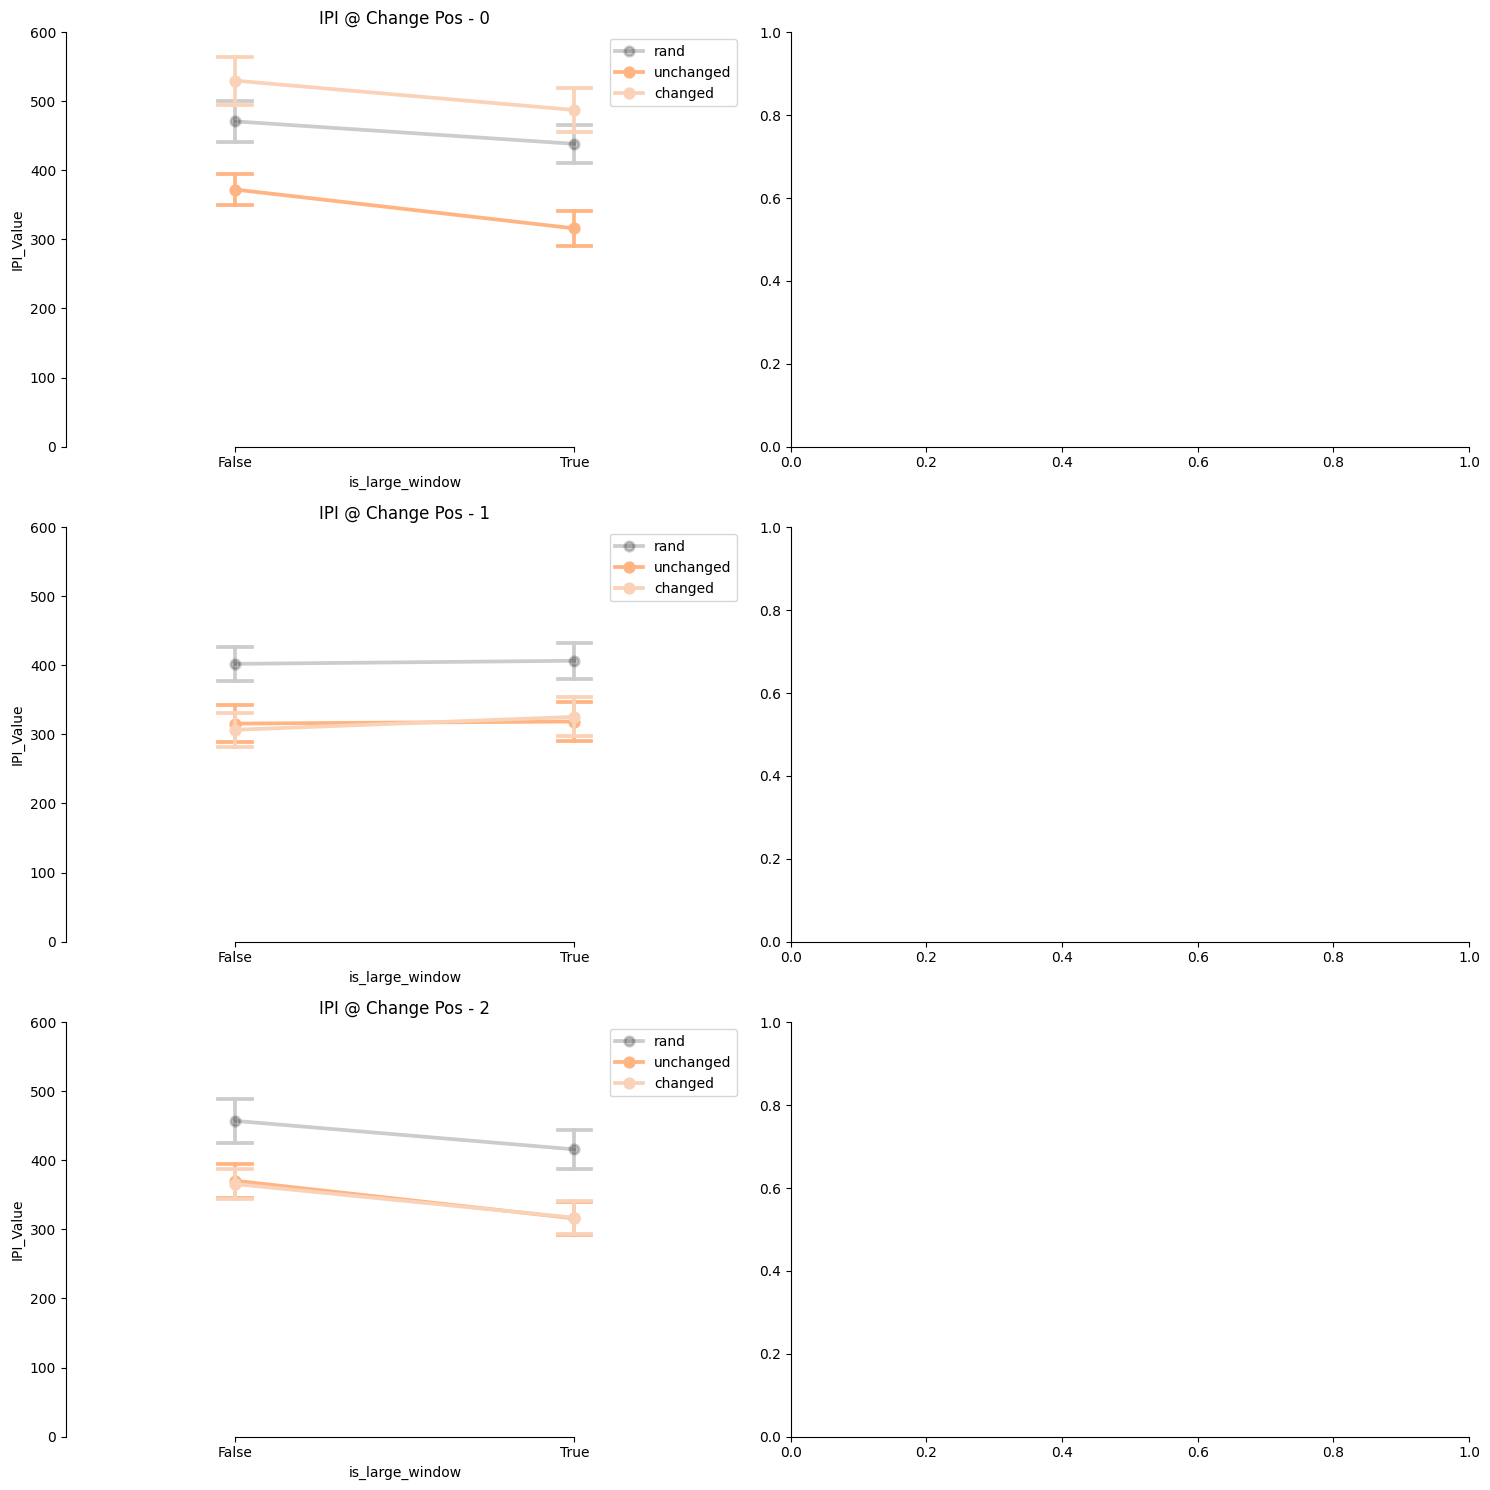

In [374]:
lookback_window = 3

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

fig, axs = plt.subplots(nrows=lookback_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

test_blocks = utils.remove_error_trials_presses(test_blocks)

test_blocks['is_large_window'] = test_blocks['windowSize'].apply(lambda x: x >= 3)


kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


for lookback in range(lookback_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 - lookback for pos in digit_change])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[(data['digitChangePos'] + 1) == (data['N'] + lookback)]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'is_large_window']).agg({
        'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data
  
        sns.pointplot(data = data, x = 'is_large_window', y = 'IPI_Value', errorbar = 'se', dodge = True, label = label, capsize = 0.1, **kwargs[label], ax = axs[lookback, 0])


        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        axs[lookback, 0].set_title(f'IPI @ Change Pos - {lookback}')
        axs[lookback, 0].set_ylim([0, 600])

        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    
    print(f"************************** IPI Change - {lookback} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())
    print("changed_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['rand', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window']).fit())




    # merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    # merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    # merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    # merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    # data_agged = merged_df.groupby('windowSize').agg({
    #         'rel': ['mean', 'sem']
    #     }).reset_index()
     
    # axs[lookback, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    # axs[lookback, 1].set_title(f'IPI @ Change Pos - {lookback}')
    # axs[lookback, 1].set_xticks(data_agged['windowSize'])
    # axs[lookback, 1].legend()



sns.despine(fig, trim = True)
fig.tight_layout()
# plt.savefig(path_figs + "Change_window_IPI.pdf", format = 'pdf')
plt.show()


                               Anova
                                     F Value  Num DF  Den DF Pr > F
-------------------------------------------------------------------
condition                            225.9639 1.0000  9.0000 0.0000
is_large_window                        7.6851 1.0000  9.0000 0.0217
IPI_Number                            10.2632 9.0000 81.0000 0.0000
condition:is_large_window              0.4198 1.0000  9.0000 0.5332
condition:IPI_Number                   3.0471 9.0000 81.0000 0.0034
is_large_window:IPI_Number             3.0601 9.0000 81.0000 0.0033
condition:is_large_window:IPI_Number   2.4515 9.0000 81.0000 0.0160



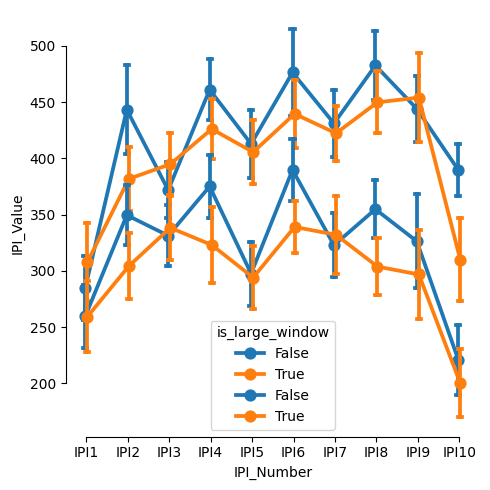

In [11]:
fig = plt.figure(figsize=(5, 5))

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

test_blocks = utils.remove_error_trials_presses(test_blocks)

test_blocks['is_large_window'] = test_blocks['windowSize'].apply(lambda x: x >= 3)


kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'IPI_Number', 'is_large_window']).agg({
    'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    data = data.iloc[index_natsorted(data['IPI_Number'])].reset_index(drop=True)

    if label in ('rand', 'unchanged'):
        sns.pointplot(data = data, x = 'IPI_Number', y = 'IPI_Value', hue= 'is_large_window',
                        errorbar = 'se', dodge = True, capsize = 0.1)

combined_data = pd.concat([finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])


print(AnovaRM(data = combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'is_large_window', 'IPI_Number']).fit())

sns.despine(fig, trim = True)
fig.tight_layout()
# plt.savefig(path_figs + "Change_window_IPI.pdf", format = 'pdf')
plt.show()


IPI:  IPI1 TtestResult(statistic=-6.227072897301422, pvalue=0.00015379275980415688, df=9)
IPI:  IPI10 TtestResult(statistic=-9.909000289456628, pvalue=3.860935446381884e-06, df=9)
IPI:  IPI2 TtestResult(statistic=-4.9557163929852805, pvalue=0.0007851208860252404, df=9)
IPI:  IPI3 TtestResult(statistic=-2.492647626393596, pvalue=0.034272798651215484, df=9)
IPI:  IPI4 TtestResult(statistic=-3.881978549751304, pvalue=0.0037201626083355347, df=9)
IPI:  IPI5 TtestResult(statistic=-8.317444720919545, pvalue=1.6198820699275035e-05, df=9)
IPI:  IPI6 TtestResult(statistic=-4.027230224848832, pvalue=0.002985389713909008, df=9)
IPI:  IPI7 TtestResult(statistic=-4.628710170391313, pvalue=0.001238938835590022, df=9)
IPI:  IPI8 TtestResult(statistic=-4.456237609054501, pvalue=0.0015858453082993353, df=9)
IPI:  IPI9 TtestResult(statistic=-6.3572288873792475, pvalue=0.0001317460033814344, df=9)


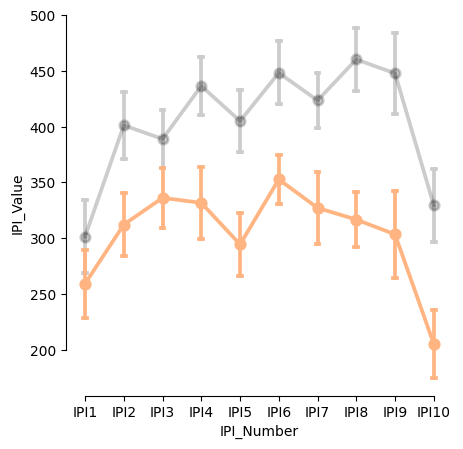

In [6]:
plt.figure(figsize=(5, 5))
cmap = cm.Pastel1
capsize = 5

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

kwargs = {'changed': {'color': trained_pallet[1], 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()


# session3_blocks['IPI_Value'] = session3_blocks.apply(utils.correct_error_presses, axis = 1)
session3_blocks = utils.remove_error_trials_presses(session3_blocks)


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    
    if (flag_trained & flag_change):

        label = 'changed'

    if (flag_trained & ~flag_change):

        label = 'unchanged'

    if (flag_rand):

        label = 'rand'

    data = data.groupby(['SubNum', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    data = data.iloc[index_natsorted(data['IPI_Number'])].reset_index(drop=True)

    if label in ('rand', 'unchanged'):
        sns.pointplot(data = data, x = 'IPI_Number', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1, **kwargs[label])


combined_data = pd.concat([finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])

for IPI in combined_data['IPI_Number'].unique():
    IPI_data = combined_data[combined_data['IPI_Number'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data[IPI_data['condition'] == 'unchanged']['IPI_Value'], IPI_data[IPI_data['condition'] == 'rand']['IPI_Value'])
    print('IPI: ', IPI, ttest_changed_vs_unchanged)

# for IPI in merged_df['dist_to_change'].unique():
#     IPI_data = merged_df[merged_df['dist_to_change'] == IPI]
#     ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
#     ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
#     ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])

    
#     # Add significance symbols just above the error bars
#     changed_mean = IPI_data['IPI_Value_changed'].mean()
#     changed_std = IPI_data['IPI_Value_changed'].std()
#     unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
#     unchanged_std = IPI_data['IPI_Value_unchanged'].std()
#     rand_mean = IPI_data['IPI_Value_rand'].mean()
#     rand_std = IPI_data['IPI_Value_rand'].std()

#     y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
#     y_pos_unchanged = unchanged_mean - unchanged_std 
#     y_pos_rand = rand_mean - rand_std

#     y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)



#     print('IPI: ', IPI, ttest_changed_vs_rand)

# # x = 3
# # delta_x = 0.1
# # y = 470
# # delta_y = 100
# # plt.plot([x + delta_x, x + 2 * delta_x, x + 2 * delta_x, x + delta_x], 
# #          [y, y, y - delta_y, y - delta_y], color = 'black', alpha = 0.5, lw = 1)


sns.despine(trim=True)

# # legend labels
# handles, _ = plt.gca().get_legend_handles_labels()
# labels = ['Random', 'Trained', 'Trained Changed']
# plt.legend(handles, labels, loc='upper right')


# plt.title(f'changed vs unchanged')
# plt.show()